<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 3: прогнозирование временных рядов</center></h2>

**Мягкий дедлайн:** 23:59MSK 19.05.2024

**Жесткий дедлайн:** 23:59MSK 26.05.2024

## Введение

In [1]:
import os
import random
import warnings

warnings.filterwarnings("ignore")

import torch
import numpy
import pandas
import etna.models
import etna.metrics
import etna.pipeline
import etna.datasets
import etna.analysis
import etna.transforms
import ruptures.detection
import etna.reconciliation

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

RANDOM_STATE = 42
def set_random_seed(seed: int = RANDOM_STATE) -> None:
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True

cuda


В данной задаче мы будем решать одну из актуальных практических задач, с которыми, в том числе, сталкиваются разработчики ETNA - прогнозирование объема необходимой наличности в банкоматах. Пожалуй, ни для кого не секрет, что отсутствие необходимой суммы в банкомате не делает клиента банка счастливее. В то же время, избыток заправленной в банкомат наличности приводит к упущенной выгоде - ведь, в конечном счете, эти деньги могли быть размещены в качестве краткосрочного депозита на межбанковском рынке. Для кредитной организации с обширной сетью банкоматов даже незначительное улучшение качества предсказания способно внести значительный вклад в прибыльность этой ветки бизнеса. 

В качестве инструмента воспользуемся библиотекой ETNA, документацию можно прочитать [тут](https://docs.etna.ai/stable/), и [чат](https://t.me/etna_support) комьюнити.

Мы будем использовать дневные данные реальных банкоматов для чего возьмем мультисегментный датасет.

In [2]:
df = pandas.read_csv('atms_daily_cash.csv', index_col = False)
kFreq = "D"

In [3]:
df["timestamp"] = pandas.to_datetime(df["datetime"])
df["target"] = df["operation_value"]
df["segment"] = df["atm_id"]
df = df[["timestamp", "segment", "target"]]

Полученные данные были просуммированы по банкоматам и дням эксплуатации, после чего залиты в gist, откуда мы и берем их.

Взглянем на то, что представляют из себя данные после этих действий:

In [4]:
df.head()

timestamp  segment     target
0 2017-08-16       74   2.059266
1 2017-08-17       74   1.029633
2 2017-08-18       74   0.686422
3 2017-08-19       74  33.301267
4 2017-08-20       74 -12.237921

## Задание 1. EDA (1.75 балл)

Проведите разведывательный анализ данных с помощью `ETNA`- постройте графики, на которых можно судить о наличии тренда, сезонности и прочих зависимостей. Проанализируйте корреляции. Какие выводы вы можете сделать?

Ссылку на туториал по EDA можно найти [тут](https://docs.etna.ai/stable/tutorials/103-EDA.html#EDA). 

In [5]:
ts = etna.datasets.TSDataset(df, freq = kFreq)
ts.describe()

start_timestamp end_timestamp  length  num_missing  num_segments  \
segments                                                                    
100           2017-08-11    2018-09-30     416            3            20   
101           2017-08-11    2018-09-30     416            3            20   
102           2017-08-02    2018-09-30     425            3            20   
103           2017-08-08    2018-09-30     419            3            20   
104           2017-08-07    2018-09-30     420            3            20   
105           2017-07-28    2018-09-30     430            3            20   
106           2017-08-09    2018-09-30     418            3            20   
74            2017-08-16    2018-09-30     411            3            20   
85            2017-08-03    2018-09-30     424            3            20   
86            2017-08-01    2018-09-30     426            3            20   
87            2017-06-09    2018-09-30     479            3            20   
88            2017-08-14    2018-09-30     413            3            20   
90            2017-07-27    2018-09-30     431            3            20   
91            2017-07-19    2018-09-30     439            3            20   
93            2017-08-12    2018-09-30     415            3            20   
94            2017-08-10    2018-09-30     417            3            20   
96            2017-07-28    2018-09-30     430            3            20   
97            2017-08-16    2018-09-30     411            3            20   
98            2017-08-17    2018-09-30     410            3            20   
99            2017-08-16    2018-09-30     411            3            20   

          num_exogs  num_regressors  num_known_future freq  
segments                                                    
100               0               0                 0    D  
101               0               0                 0    D  
102               0               0                 0    D  
103               0               0                 0    D  
104               0               0                 0    D  
105               0               0                 0    D  
106               0               0                 0    D  
74                0               0                 0    D  
85                0               0                 0    D  
86                0               0                 0    D  
87                0               0                 0    D  
88                0               0                 0    D  
90                0               0                 0    D  
91                0               0                 0    D  
93                0               0                 0    D  
94                0               0                 0    D  
96                0               0                 0    D  
97                0               0                 0    D  
98                0               0                 0    D  
99                0               0                 0    D

In [6]:
N_SEGMENTS = 6
SEGMENTS = ts.segments[:N_SEGMENTS]

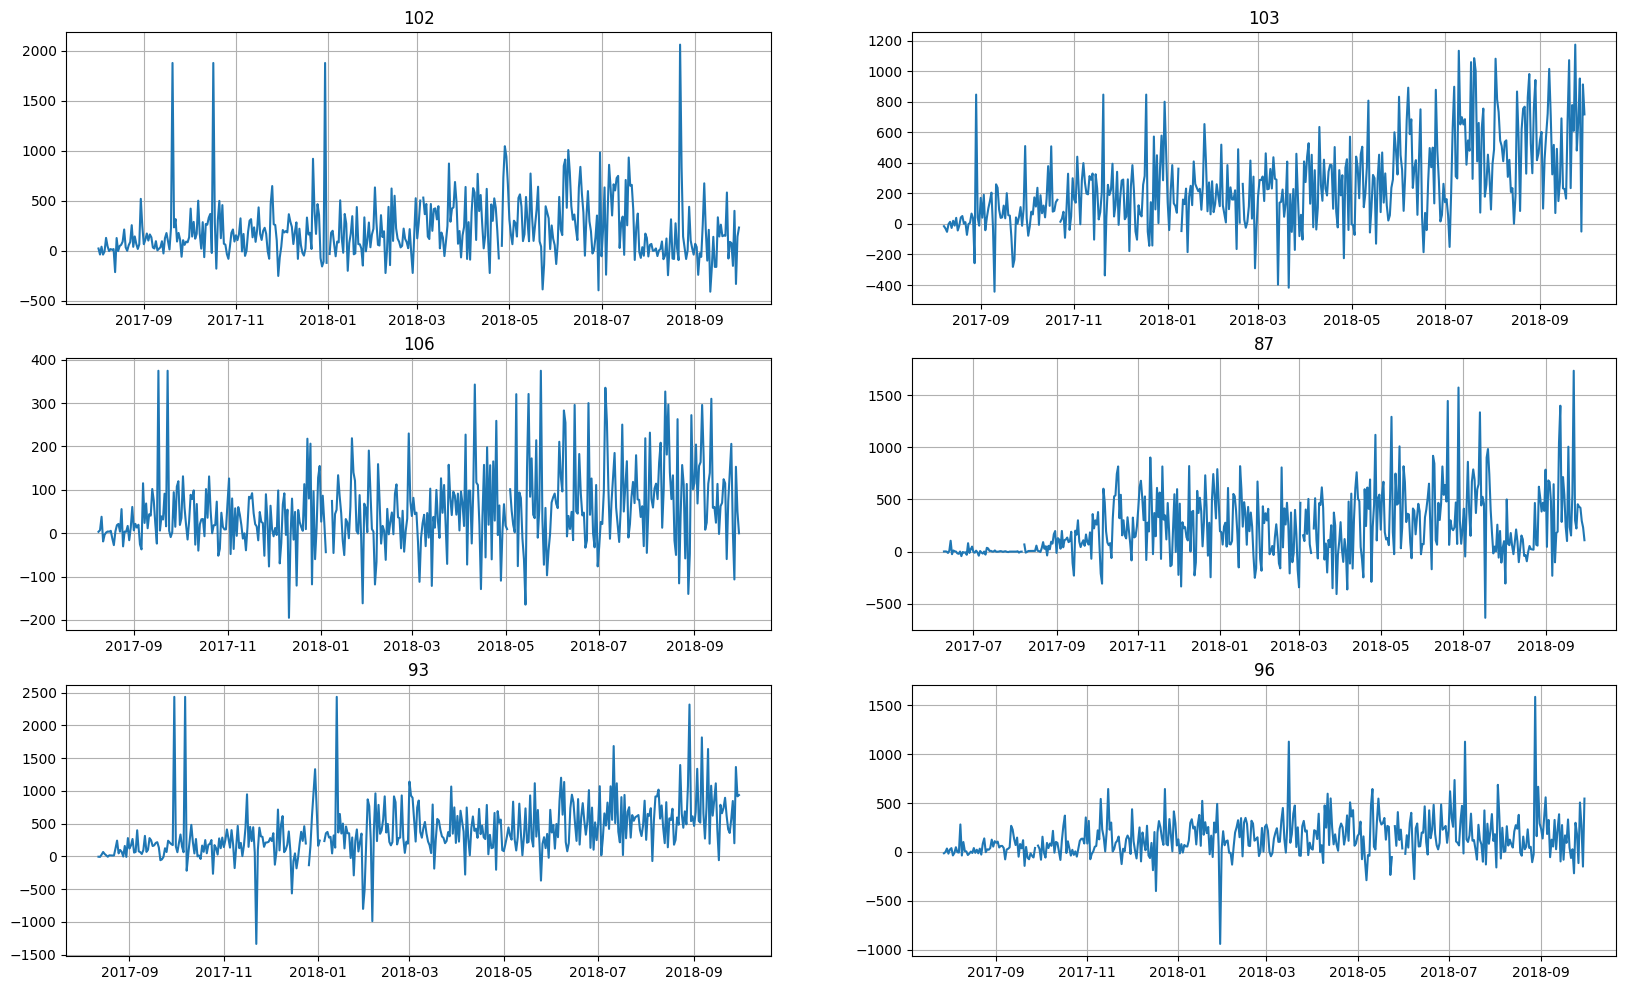

In [7]:
set_random_seed()
ts.plot(n_segments = N_SEGMENTS, figsize = (10, 4))

Какие-то закономерности видны, но в таком виде сформулировать их достаточно трудно.

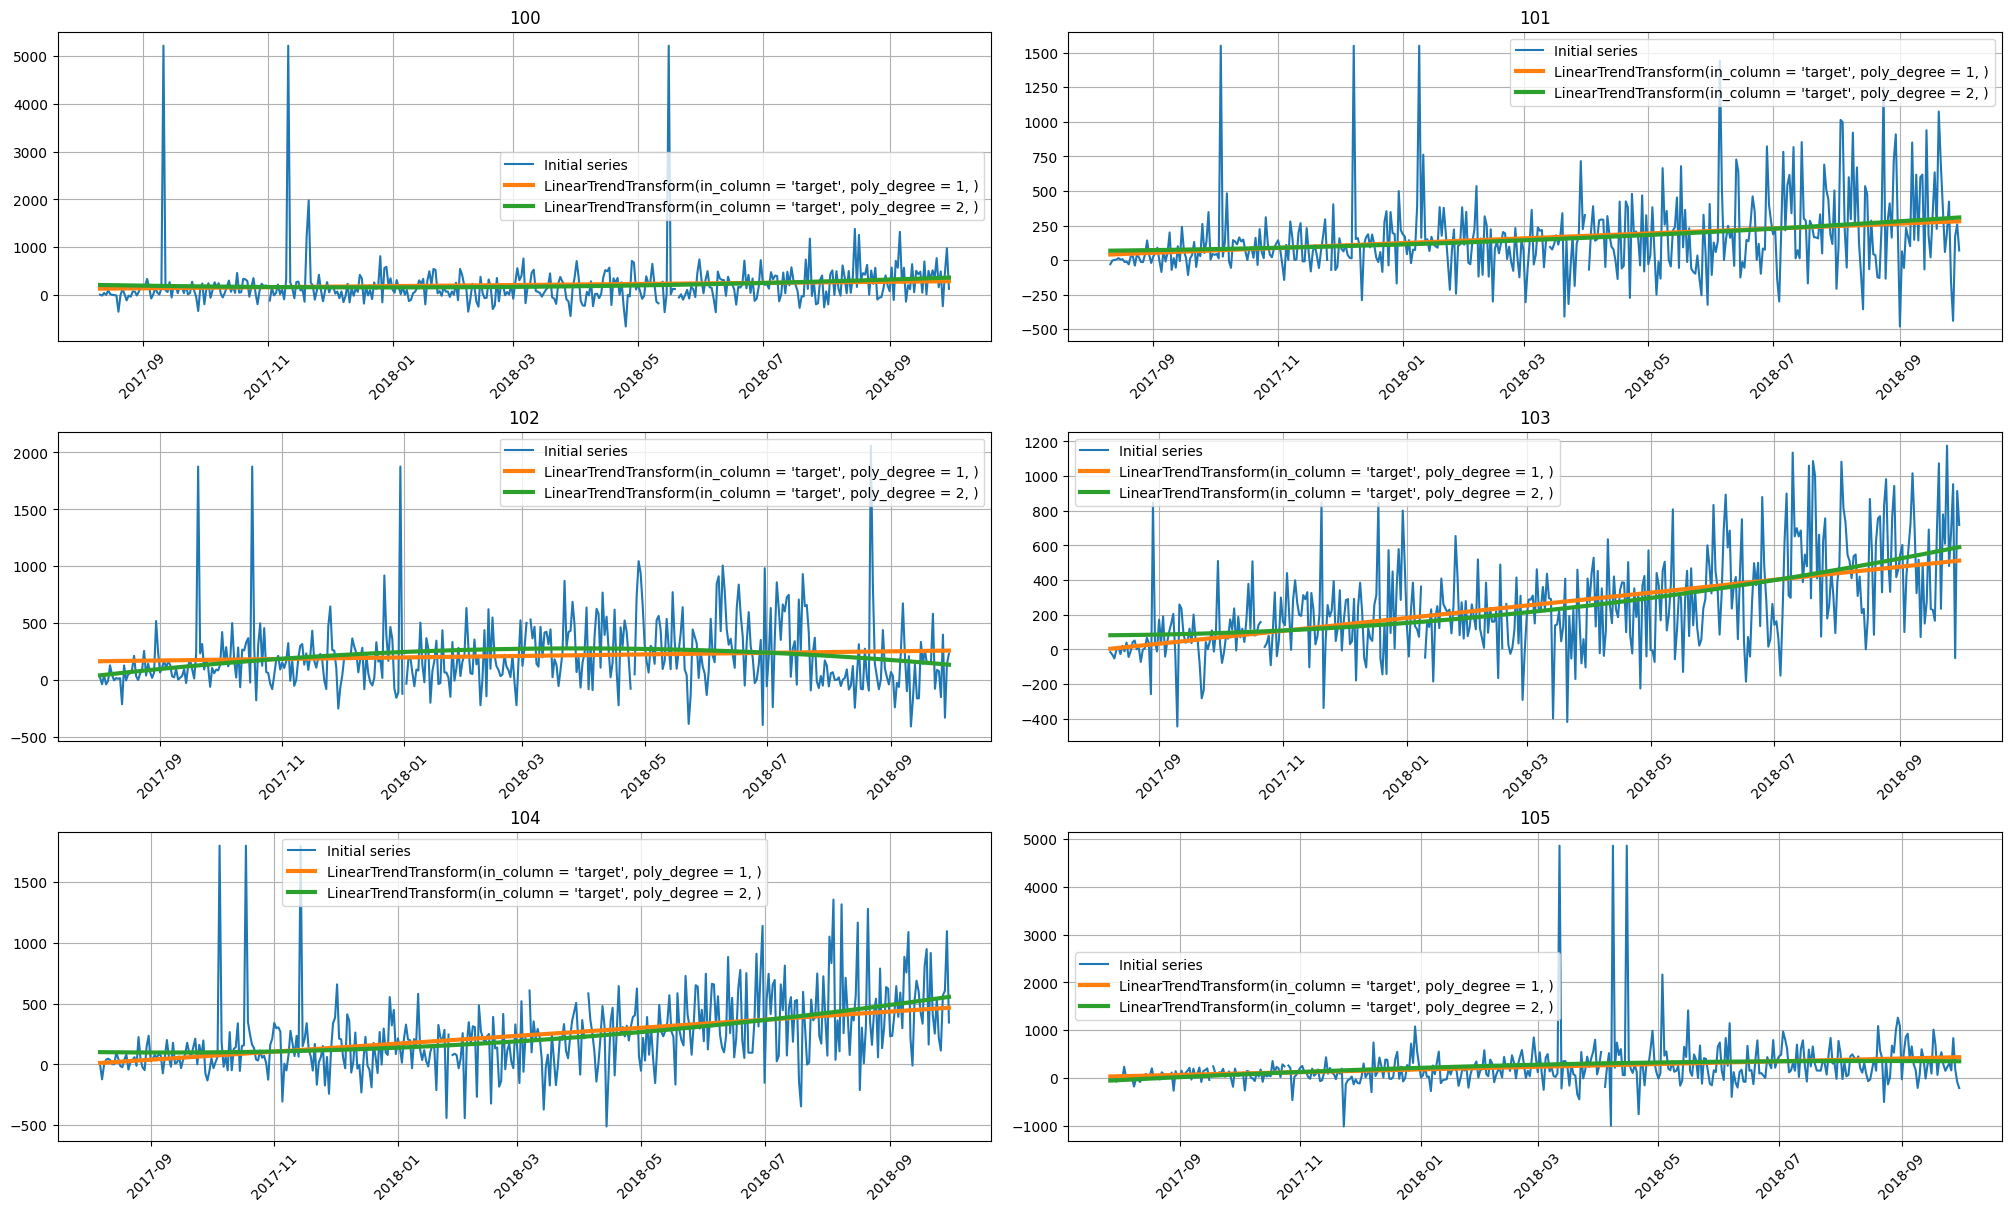

In [8]:
set_random_seed()
etna.analysis.plot_trend(ts, segments = SEGMENTS, figsize = (10, 4), trend_transform = [
    etna.transforms.LinearTrendTransform(in_column = "target", poly_degree = 1),
    etna.transforms.LinearTrendTransform(in_column = "target", poly_degree = 2),
])

Почти для всех компонент наблюдается возрастающий тренд.

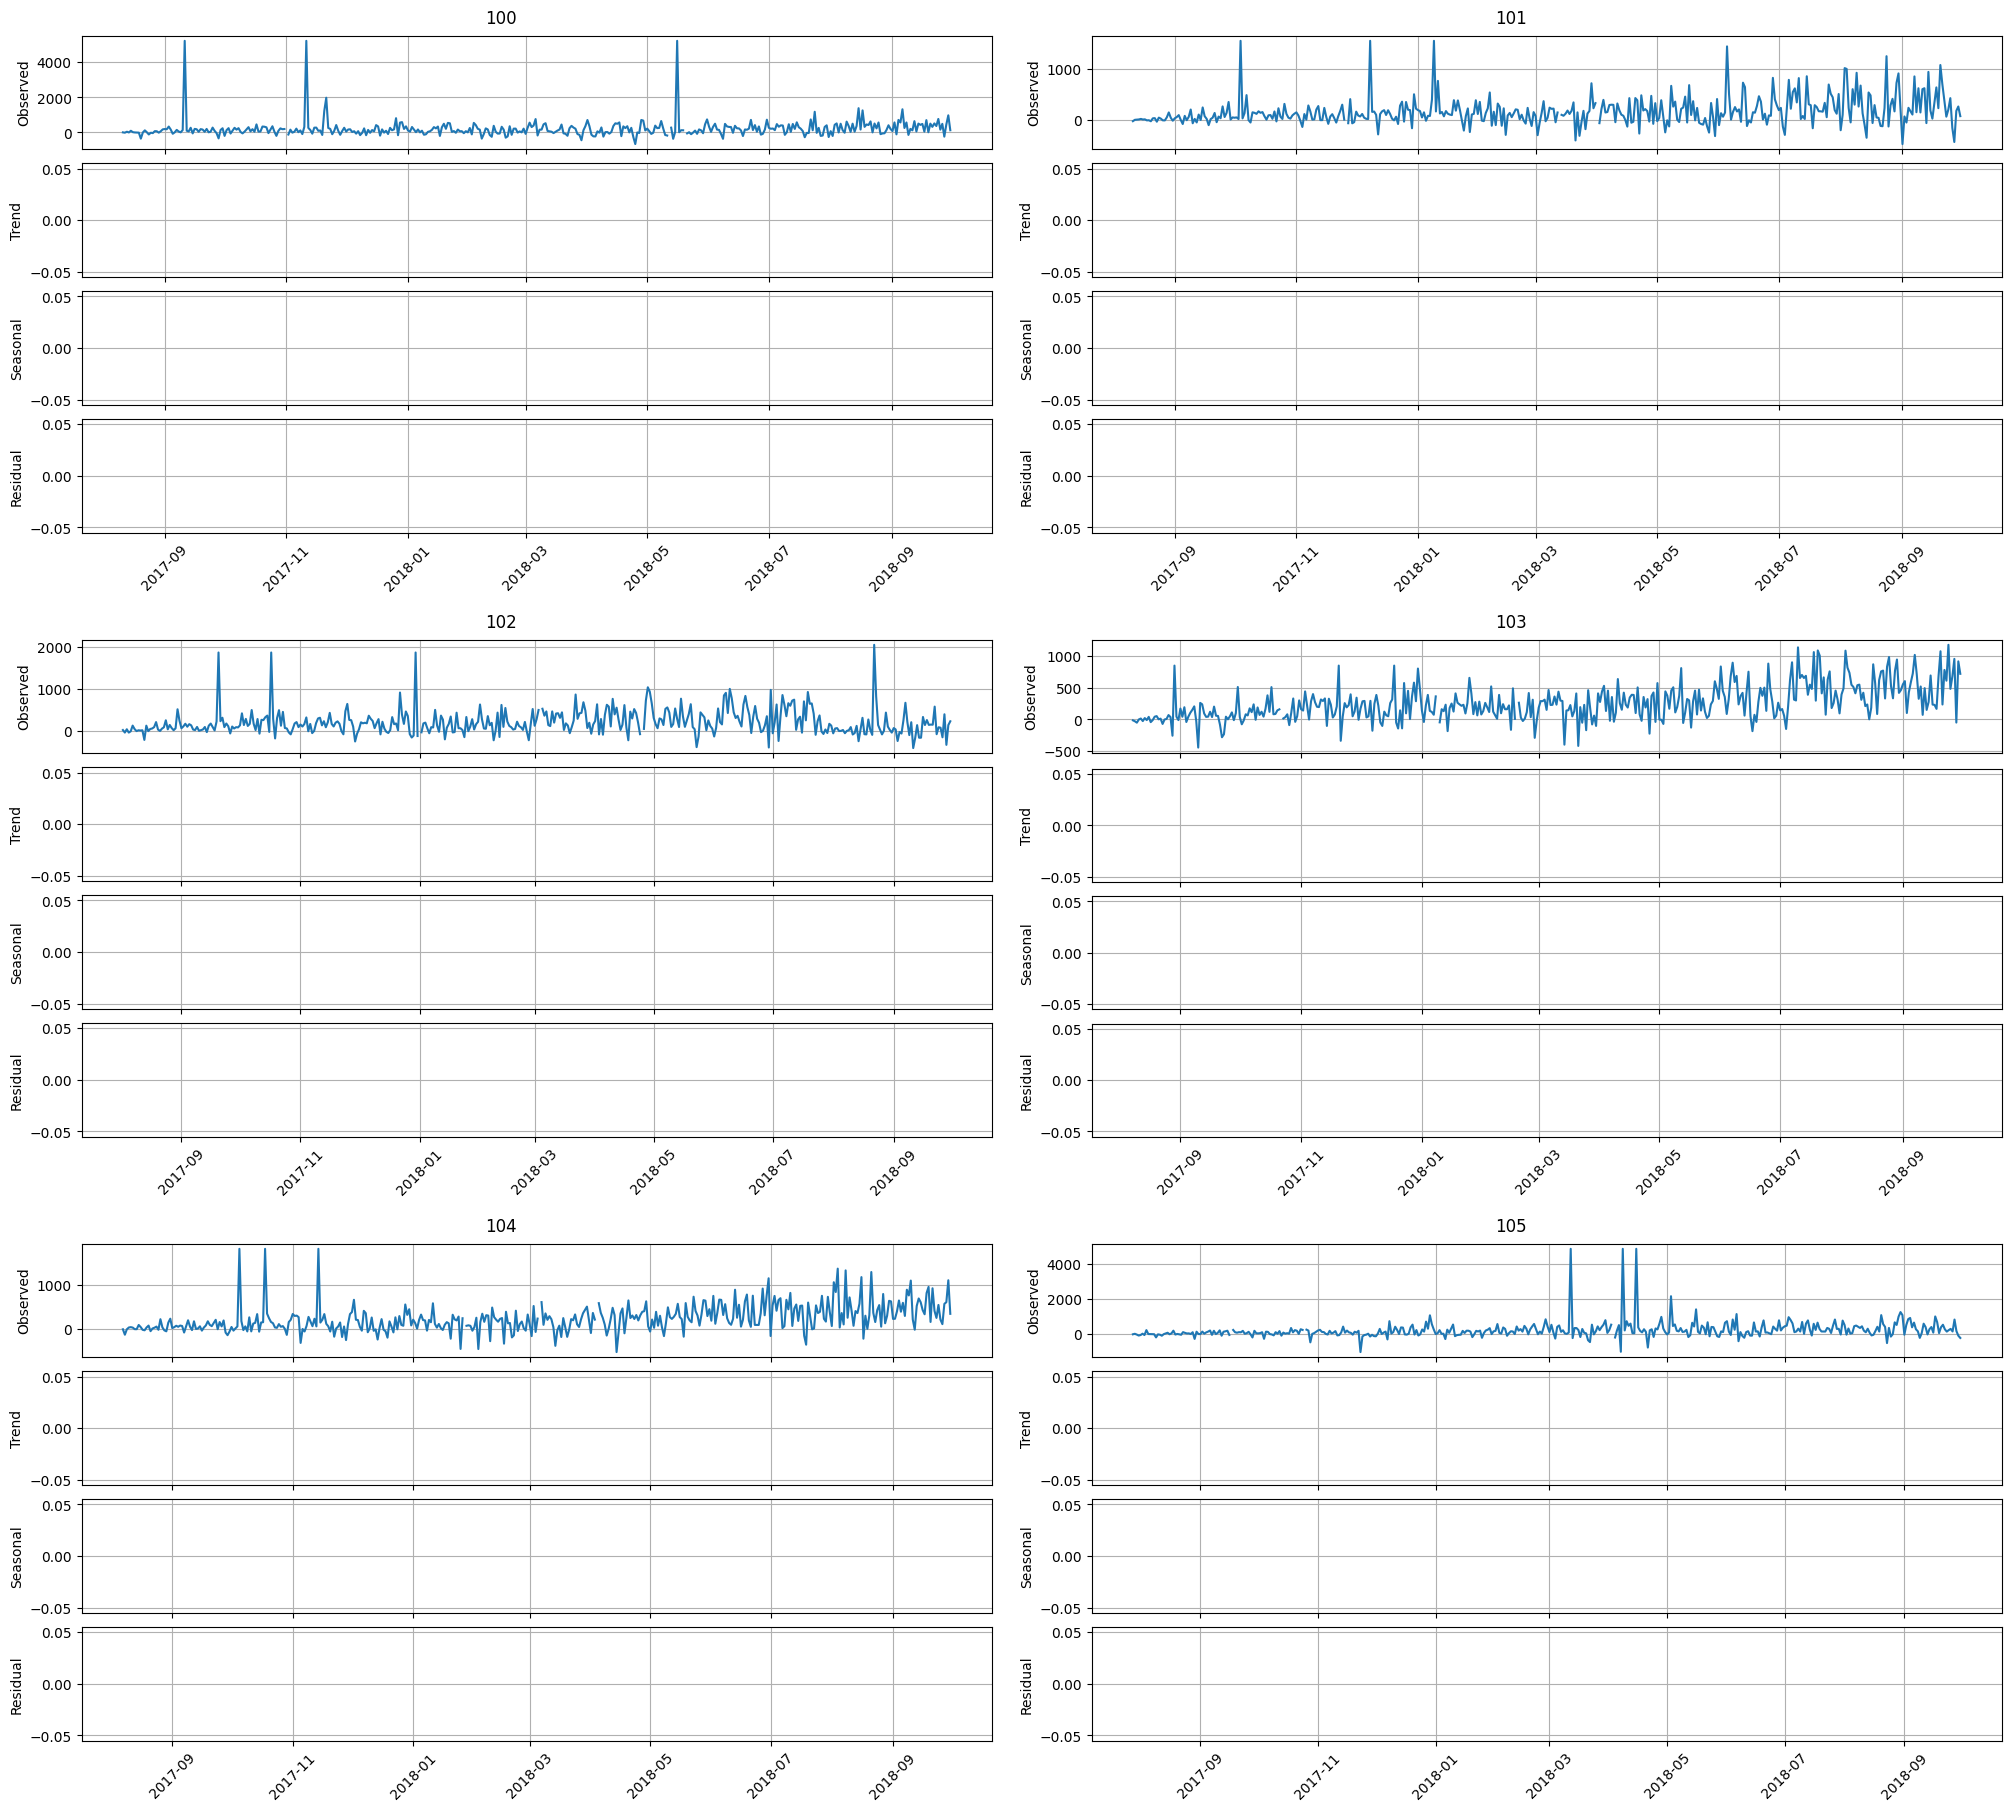

In [9]:
set_random_seed()
etna.analysis.stl_plot(ts, segments = SEGMENTS, figsize = (10, 6), period = 52)

In [10]:
try:
    etna.analysis.plot_time_series_with_change_points(
        ts, segments = SEGMENTS, figsize = (10, 2),
        change_points = etna.analysis.find_change_points(ts, 'target', change_point_model = ruptures.detection.Binseg(), pen = 1e5)
    )
except Exception as e:
    print(e)

The input column contains NaNs in the middle of the series! Try to use the imputer.


Periodogram can't be calculated on segment with NaNs inside: 100


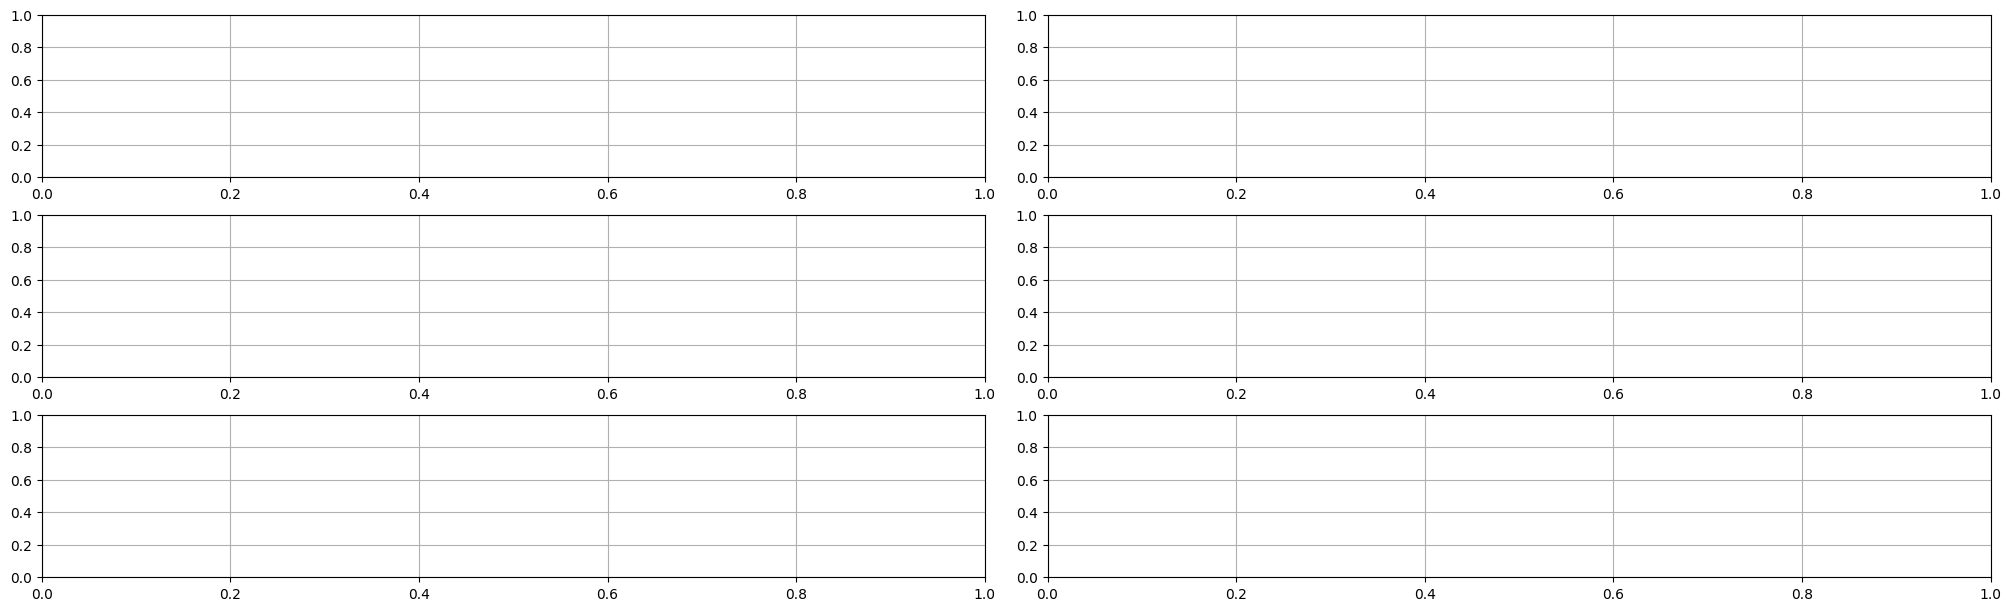

In [11]:
try:
    set_random_seed()
    etna.analysis.plot_periodogram(ts, period = 365.2425, amplitude_aggregation_mode = "per-segment", segments = SEGMENTS, figsize = (10, 2))
except Exception as e:
    print(e)

Ожиадемо, stl_plot (как и некоторые другие методы) не работают при наличии пропущенных значений в ряду. Посмотрим на результаты этих методов в следующем задании.

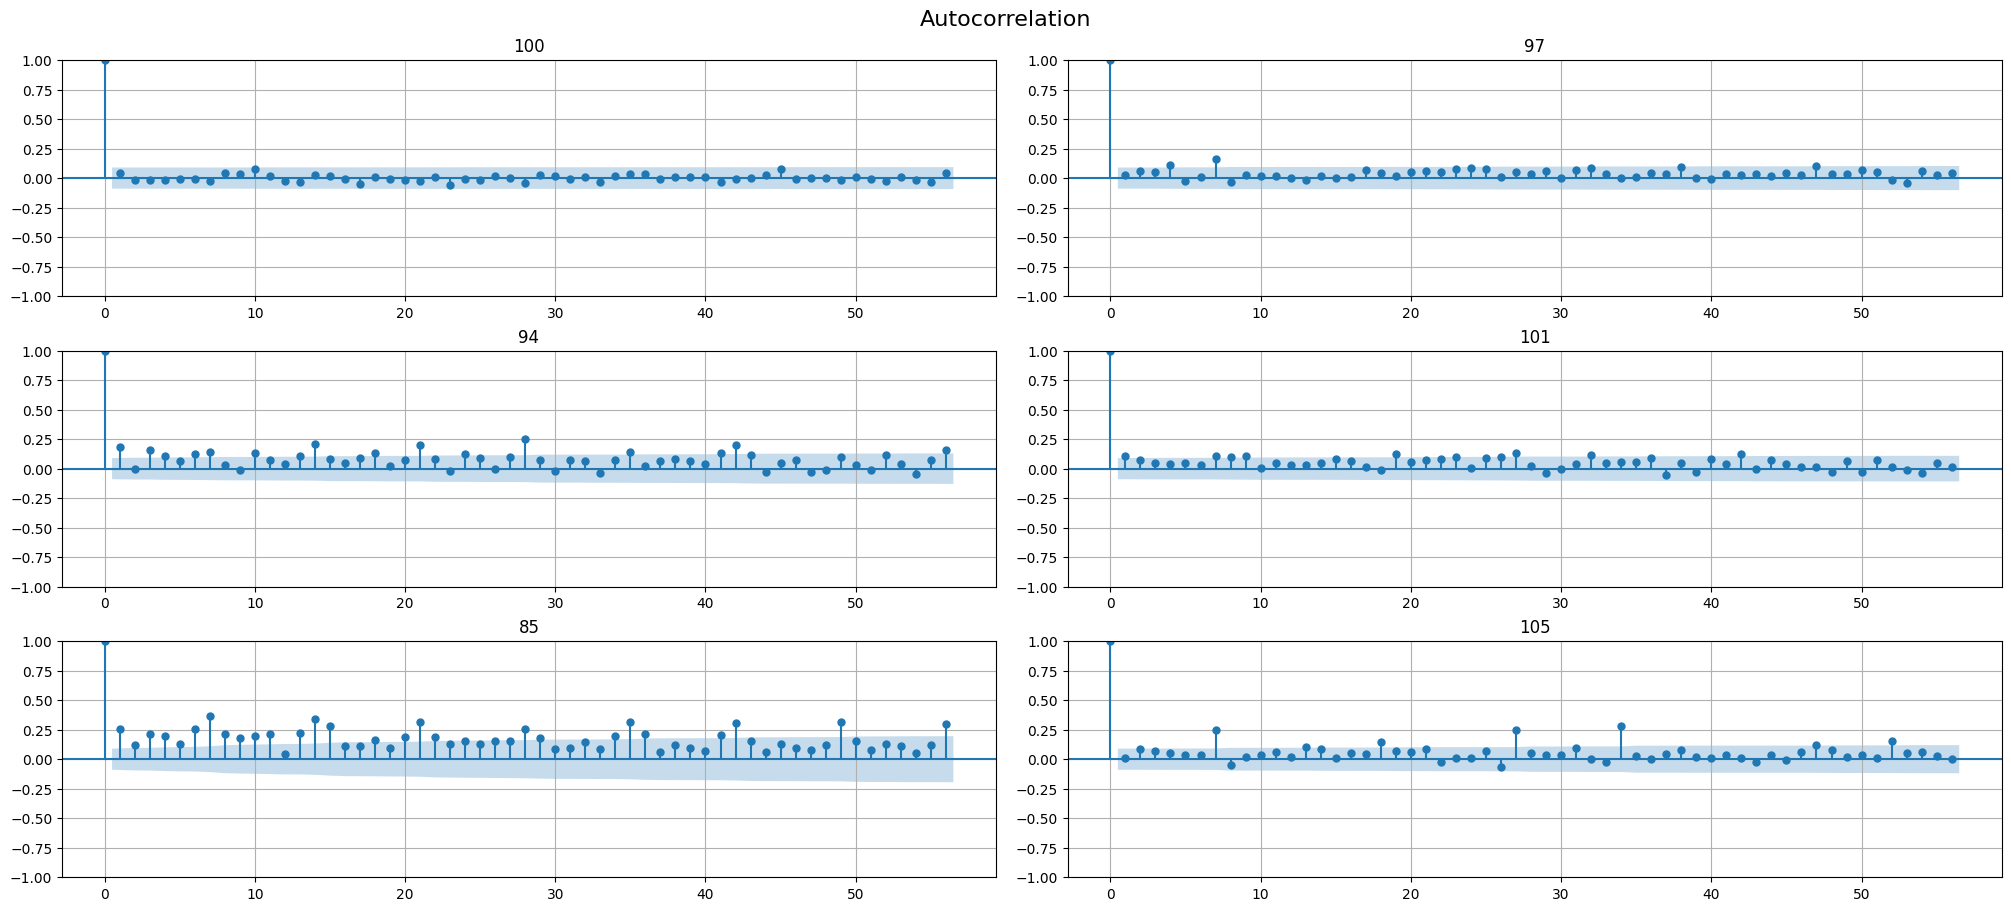

In [12]:
set_random_seed()
etna.analysis.acf_plot(ts, lags = 56, n_segments = N_SEGMENTS, figsize = (10, 3))

There is a NaN in the middle of the time series!


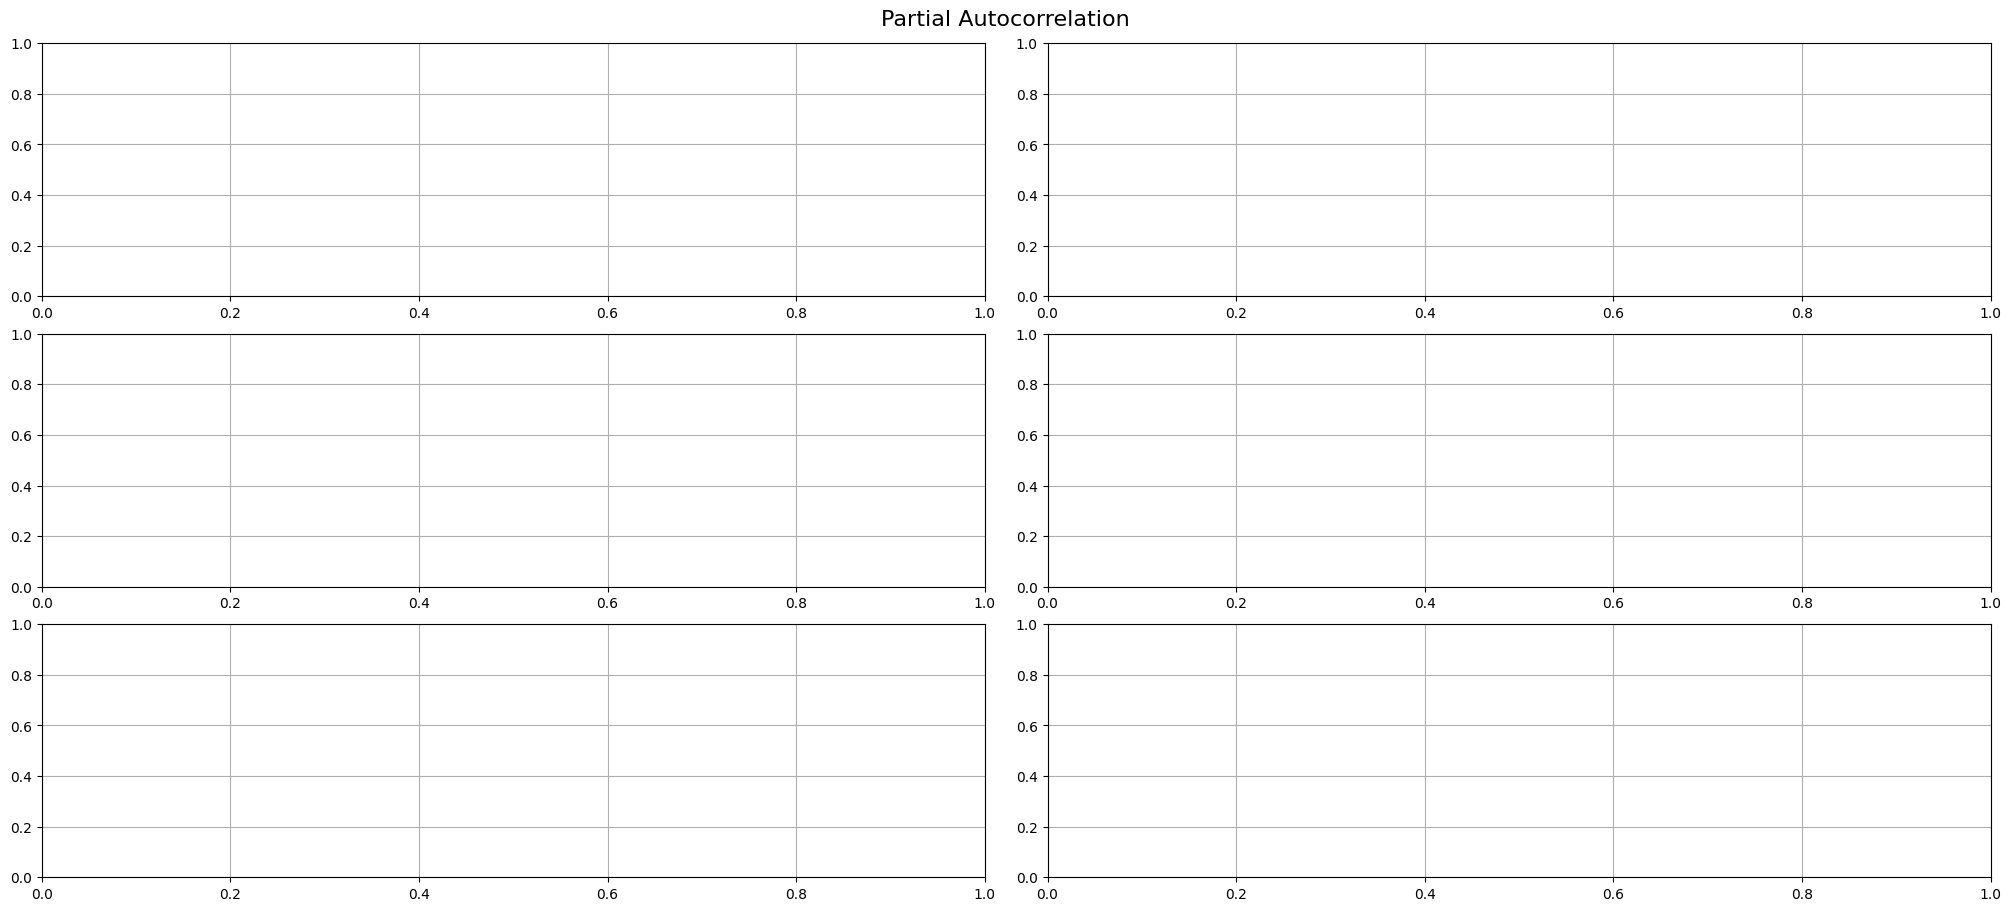

In [13]:
try:
    set_random_seed()
    etna.analysis.acf_plot(ts, lags = 56, partial = True, n_segments = N_SEGMENTS, figsize = (10, 3))
except Exception as e:
    print(e)

Видны пики с интервалом примерно в 7 дней. Это говорит о наличии недельной сезонности в данных, хотя она и не очень ярко выражена

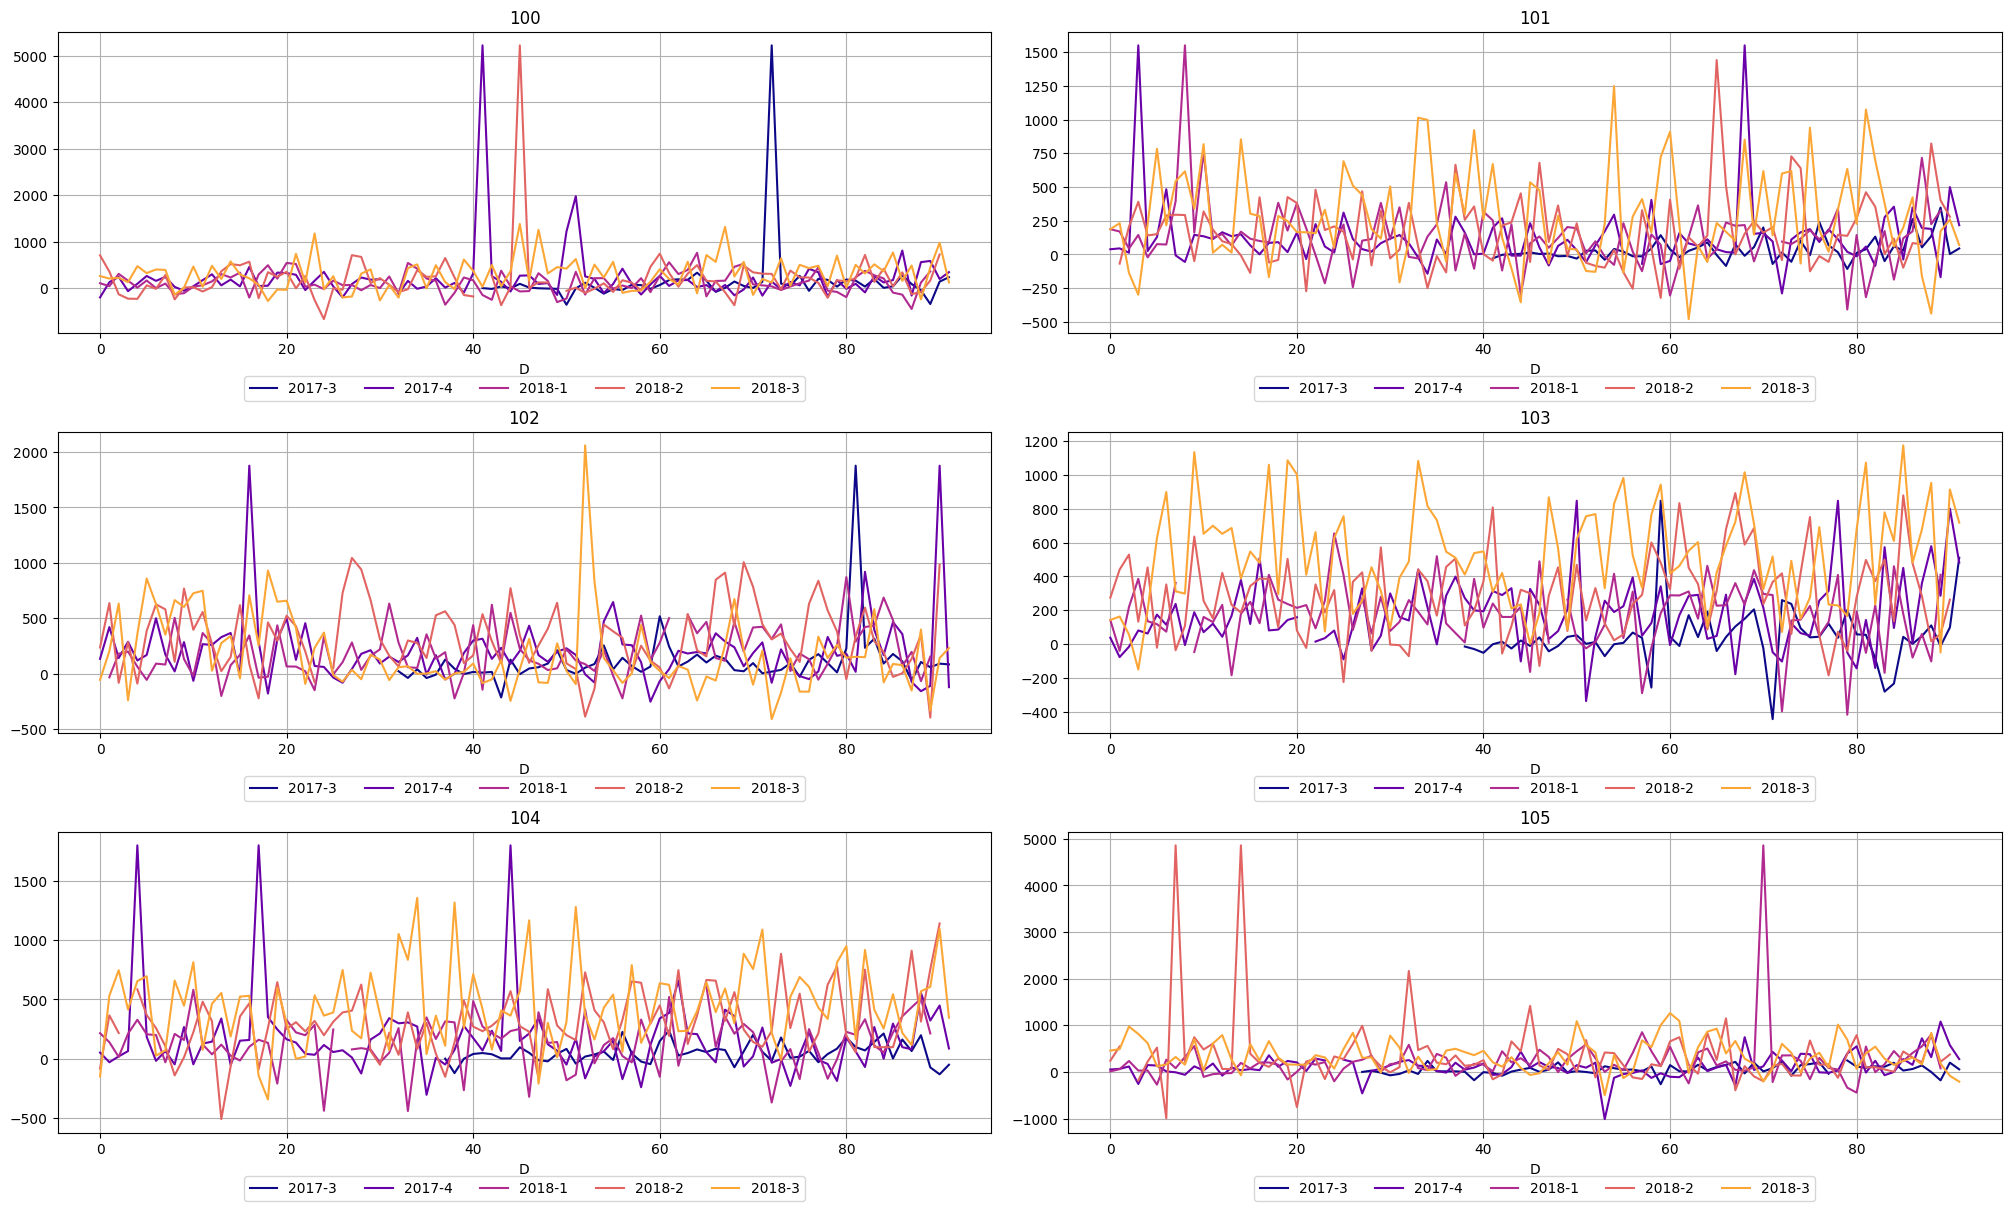

In [14]:
set_random_seed()
etna.analysis.seasonal_plot(ts, segments = SEGMENTS, figsize = (10, 4), cycle = "quarter")

Отдельные элементы сезонности действительно наблюдаются, хотя явные закономерности выделить и достаточно сложно.

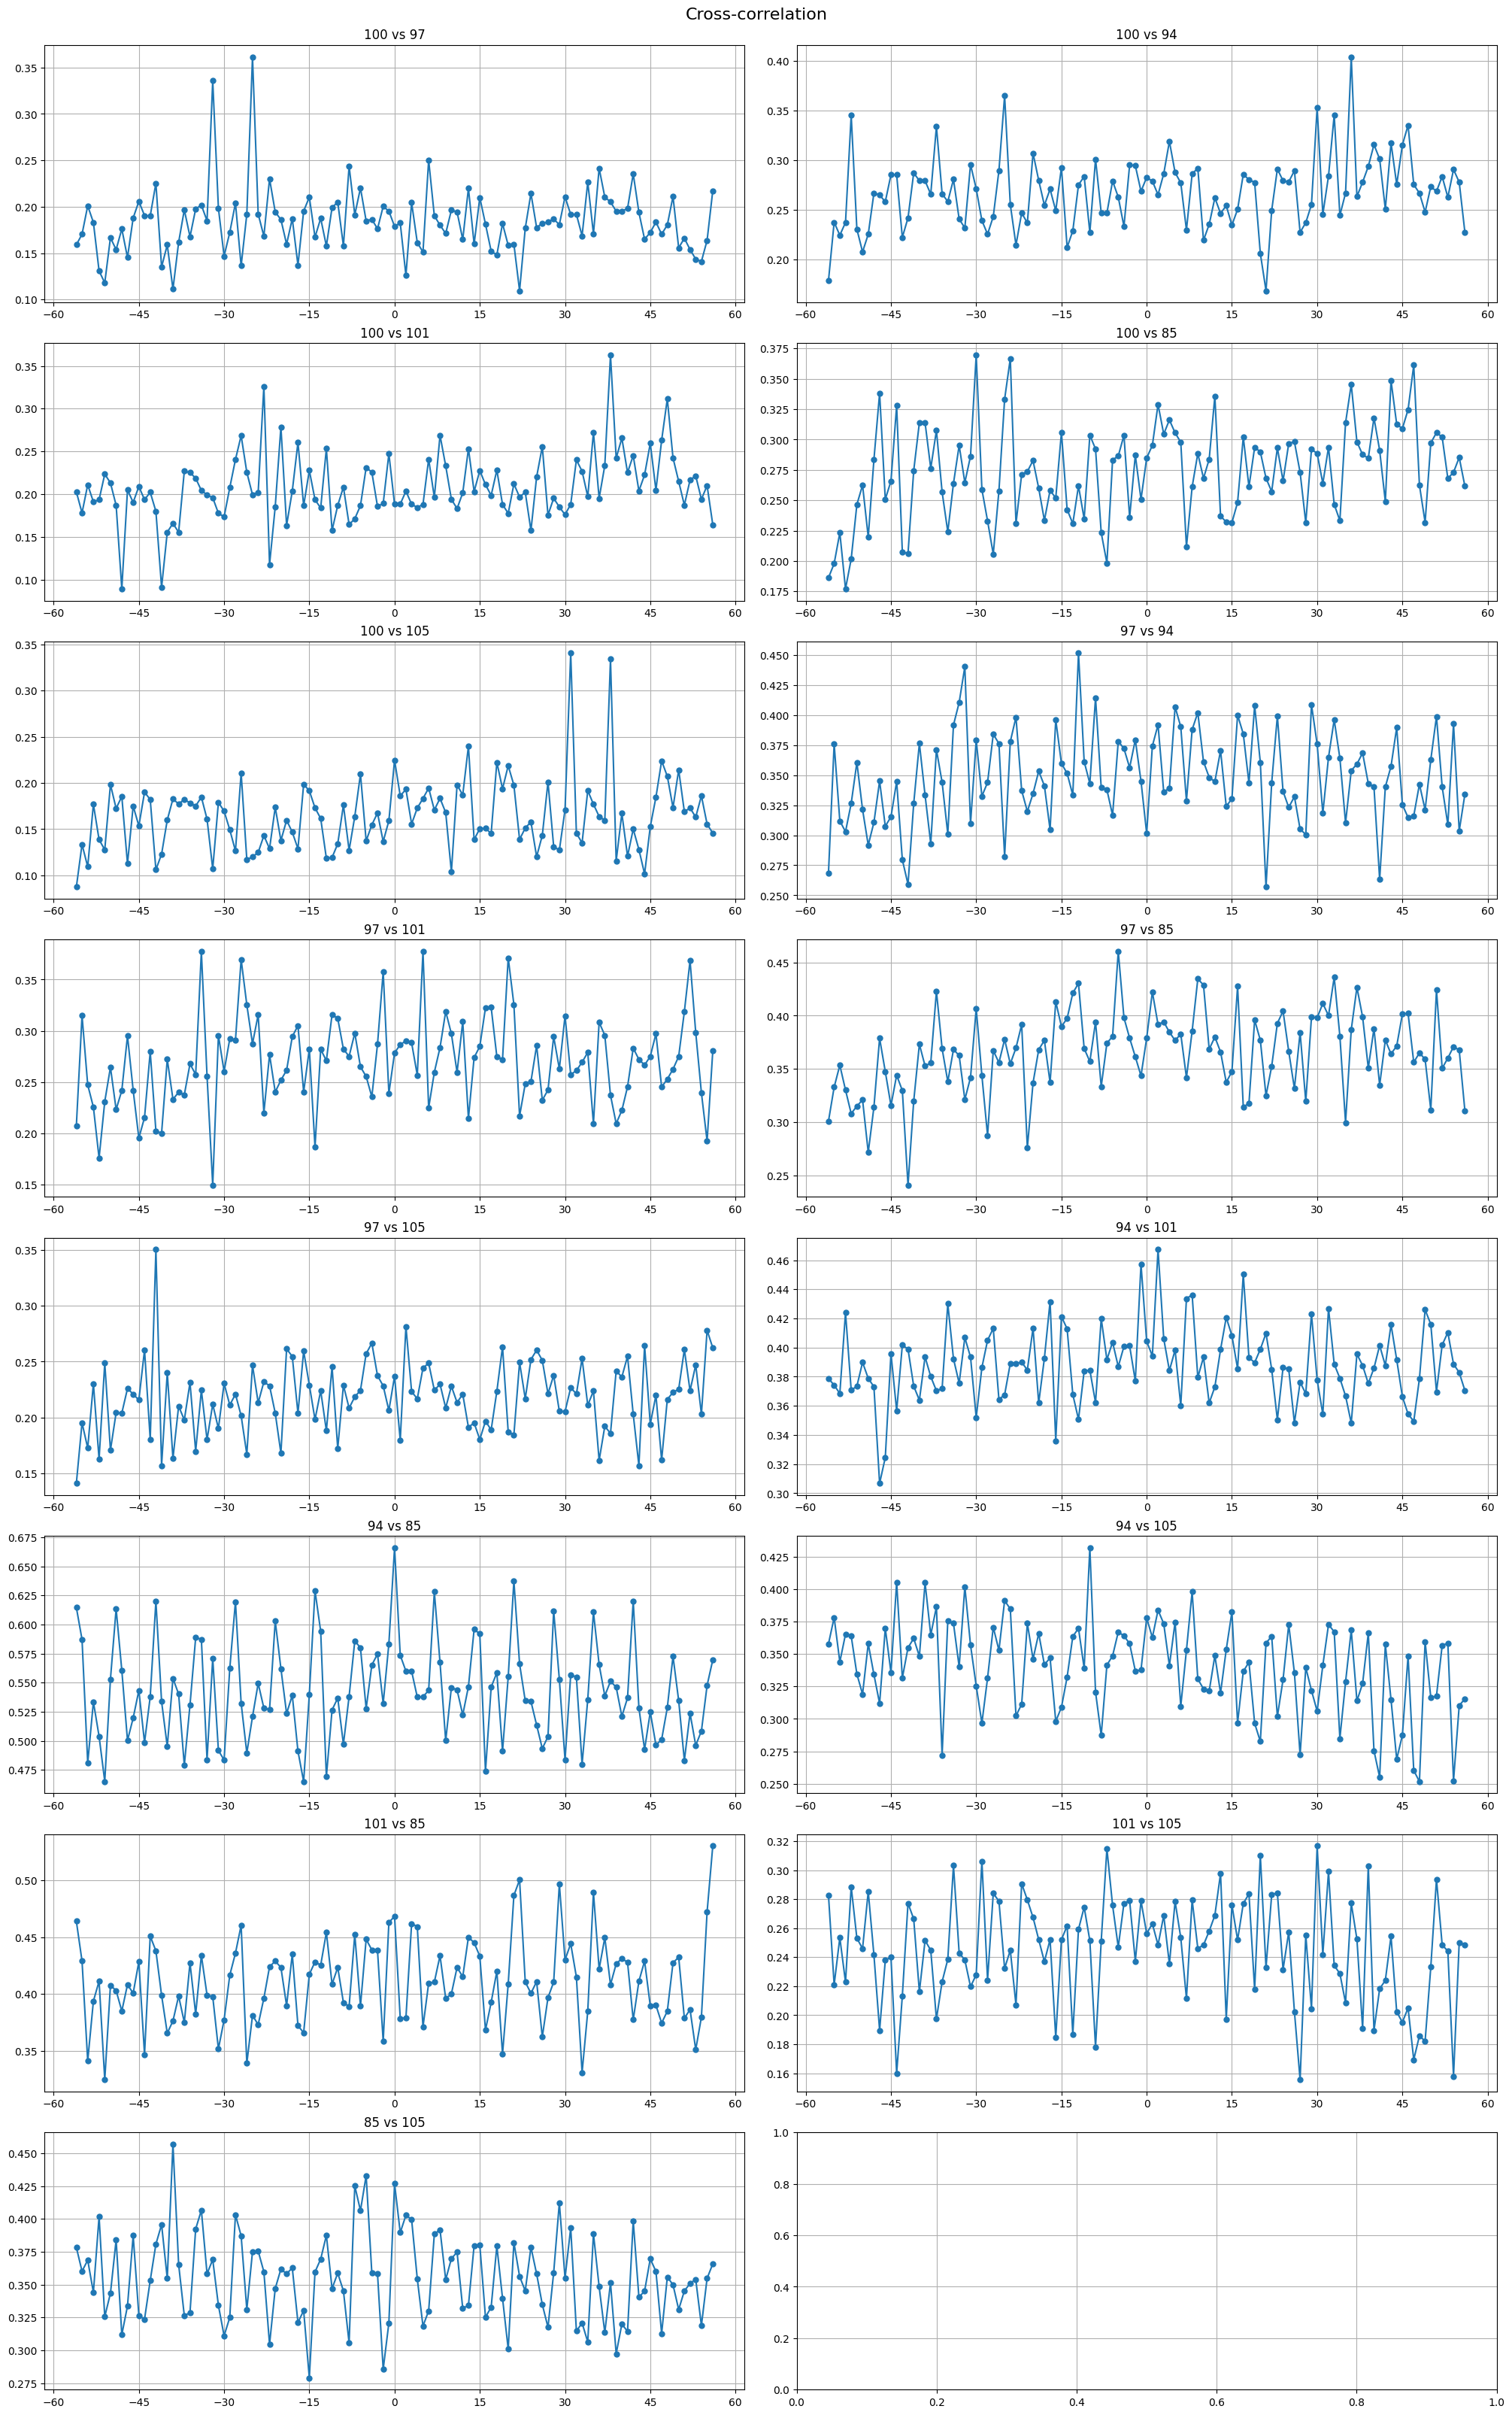

In [15]:
set_random_seed()
etna.analysis.cross_corr_plot(ts, n_segments = N_SEGMENTS, maxlags = 56, figsize = (10, 4))

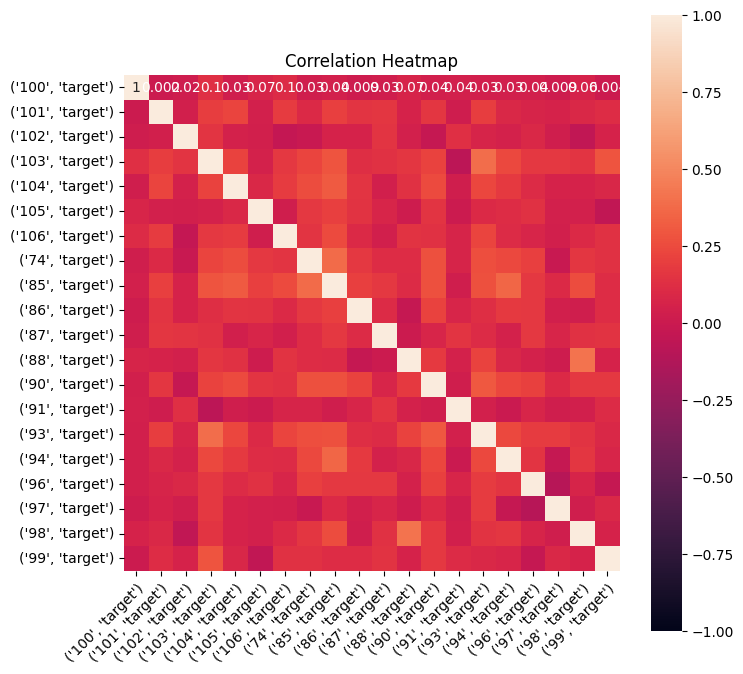

In [16]:
set_random_seed()
etna.analysis.plot_correlation_matrix(ts, figsize = (8, 8))

Кросс-корреляции также ненулевые: разные банкоматы имеют общие закономерности

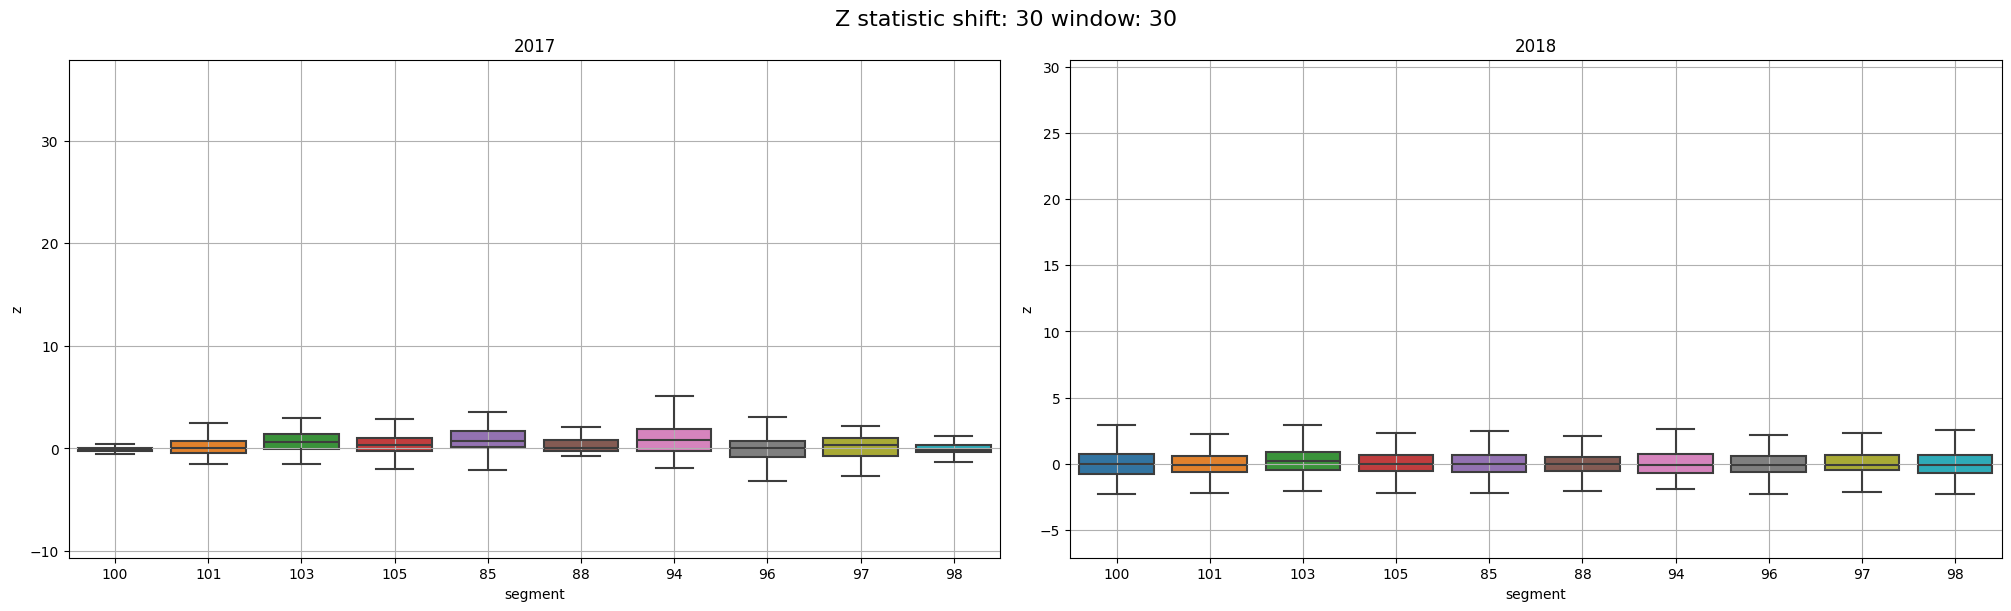

In [17]:
set_random_seed()
etna.analysis.distribution_plot(ts, figsize = (10, 6), freq = "1Y")

### Вывод

Таким образом:
1. В данных наблюдается недельная сезонность, хотя заметить это "на глаз" достаточно сложно.
2. Общий тренд для большинства банкоматов - небольшое возрастание количества выданной наличности.
3. Данные разных банкоматов заметно коррелированы, прослеживаются общие закономерности.
4. Многие методы ETNA не позволяет производить анализ временных рядов, содержащих пропущенные значения.

## Задание 2. Работа с пропущенными значениями и выбросами (1 балл)

Проанализируйте, есть ли в данных пропущенные значения, и подберите оптимальный метод их заполнения средствами ETNA. Какие методы вы выберете и почему? Совет: возможно, лучше сохранить заполненные данные в отдельный объект, поскольку некоторые модели заполняют пропуски встроенными методами, и подача на вход "сырых" данных (на языке временных рядов это данные с нерегулярными интервалами) может принести лучший результат.

Импорты всех необходимых компонент произведите самостоятельно.

In [18]:
ts.describe()

start_timestamp end_timestamp  length  num_missing  num_segments  \
segments                                                                    
100           2017-08-11    2018-09-30     416            3            20   
101           2017-08-11    2018-09-30     416            3            20   
102           2017-08-02    2018-09-30     425            3            20   
103           2017-08-08    2018-09-30     419            3            20   
104           2017-08-07    2018-09-30     420            3            20   
105           2017-07-28    2018-09-30     430            3            20   
106           2017-08-09    2018-09-30     418            3            20   
74            2017-08-16    2018-09-30     411            3            20   
85            2017-08-03    2018-09-30     424            3            20   
86            2017-08-01    2018-09-30     426            3            20   
87            2017-06-09    2018-09-30     479            3            20   
88            2017-08-14    2018-09-30     413            3            20   
90            2017-07-27    2018-09-30     431            3            20   
91            2017-07-19    2018-09-30     439            3            20   
93            2017-08-12    2018-09-30     415            3            20   
94            2017-08-10    2018-09-30     417            3            20   
96            2017-07-28    2018-09-30     430            3            20   
97            2017-08-16    2018-09-30     411            3            20   
98            2017-08-17    2018-09-30     410            3            20   
99            2017-08-16    2018-09-30     411            3            20   

          num_exogs  num_regressors  num_known_future freq  
segments                                                    
100               0               0                 0    D  
101               0               0                 0    D  
102               0               0                 0    D  
103               0               0                 0    D  
104               0               0                 0    D  
105               0               0                 0    D  
106               0               0                 0    D  
74                0               0                 0    D  
85                0               0                 0    D  
86                0               0                 0    D  
87                0               0                 0    D  
88                0               0                 0    D  
90                0               0                 0    D  
91                0               0                 0    D  
93                0               0                 0    D  
94                0               0                 0    D  
96                0               0                 0    D  
97                0               0                 0    D  
98                0               0                 0    D  
99                0               0                 0    D

Длительности записей для всех банкоматов разные, в то время как конечная дата совпадает. Следовательно, пропущенные значения есть в начале большинства записей. \
Более того, пропущенные значения есть и в самих записях: по 3 для каждого банкомата. Так как в данных наблюдается недельная сезонность, заполним их авторегрессивно. Таким образом должны получиться наиболее реалистичные данные, основанные на настоящем поведении ряда. Если сезонных данных недостаточно для заполнения (например, пропущено значение в начале записи), заполним оставшиеся пропущенные значения скользящим средним. Так как пропусков немного, выбор стратегии их заполнения не должен оказываться значимого влияния на результаты.

In [19]:
seasonal_imputer = etna.transforms.TimeSeriesImputerTransform(strategy = 'seasonal_nonautoreg', seasonality = 7)
running_mean_imputer = etna.transforms.TimeSeriesImputerTransform(strategy = 'running_mean')
ts_nona = running_mean_imputer.fit_transform(seasonal_imputer.fit_transform(etna.datasets.TSDataset(df, freq = kFreq)))
ts_nona.describe()

start_timestamp end_timestamp  length  num_missing  num_segments  \
segments                                                                    
100           2017-08-11    2018-09-30     416            0            20   
101           2017-08-11    2018-09-30     416            0            20   
102           2017-08-02    2018-09-30     425            0            20   
103           2017-08-08    2018-09-30     419            0            20   
104           2017-08-07    2018-09-30     420            0            20   
105           2017-07-28    2018-09-30     430            0            20   
106           2017-08-09    2018-09-30     418            0            20   
74            2017-08-16    2018-09-30     411            0            20   
85            2017-08-03    2018-09-30     424            0            20   
86            2017-08-01    2018-09-30     426            0            20   
87            2017-06-09    2018-09-30     479            0            20   
88            2017-08-14    2018-09-30     413            0            20   
90            2017-07-27    2018-09-30     431            0            20   
91            2017-07-19    2018-09-30     439            0            20   
93            2017-08-12    2018-09-30     415            0            20   
94            2017-08-10    2018-09-30     417            0            20   
96            2017-07-28    2018-09-30     430            0            20   
97            2017-08-16    2018-09-30     411            0            20   
98            2017-08-17    2018-09-30     410            0            20   
99            2017-08-16    2018-09-30     411            0            20   

          num_exogs  num_regressors  num_known_future freq  
segments                                                    
100               0               0                 0    D  
101               0               0                 0    D  
102               0               0                 0    D  
103               0               0                 0    D  
104               0               0                 0    D  
105               0               0                 0    D  
106               0               0                 0    D  
74                0               0                 0    D  
85                0               0                 0    D  
86                0               0                 0    D  
87                0               0                 0    D  
88                0               0                 0    D  
90                0               0                 0    D  
91                0               0                 0    D  
93                0               0                 0    D  
94                0               0                 0    D  
96                0               0                 0    D  
97                0               0                 0    D  
98                0               0                 0    D  
99                0               0                 0    D

Завершим разведывательный анализ данных, используя методы, неприменимые к рядам с пропущенными значениями

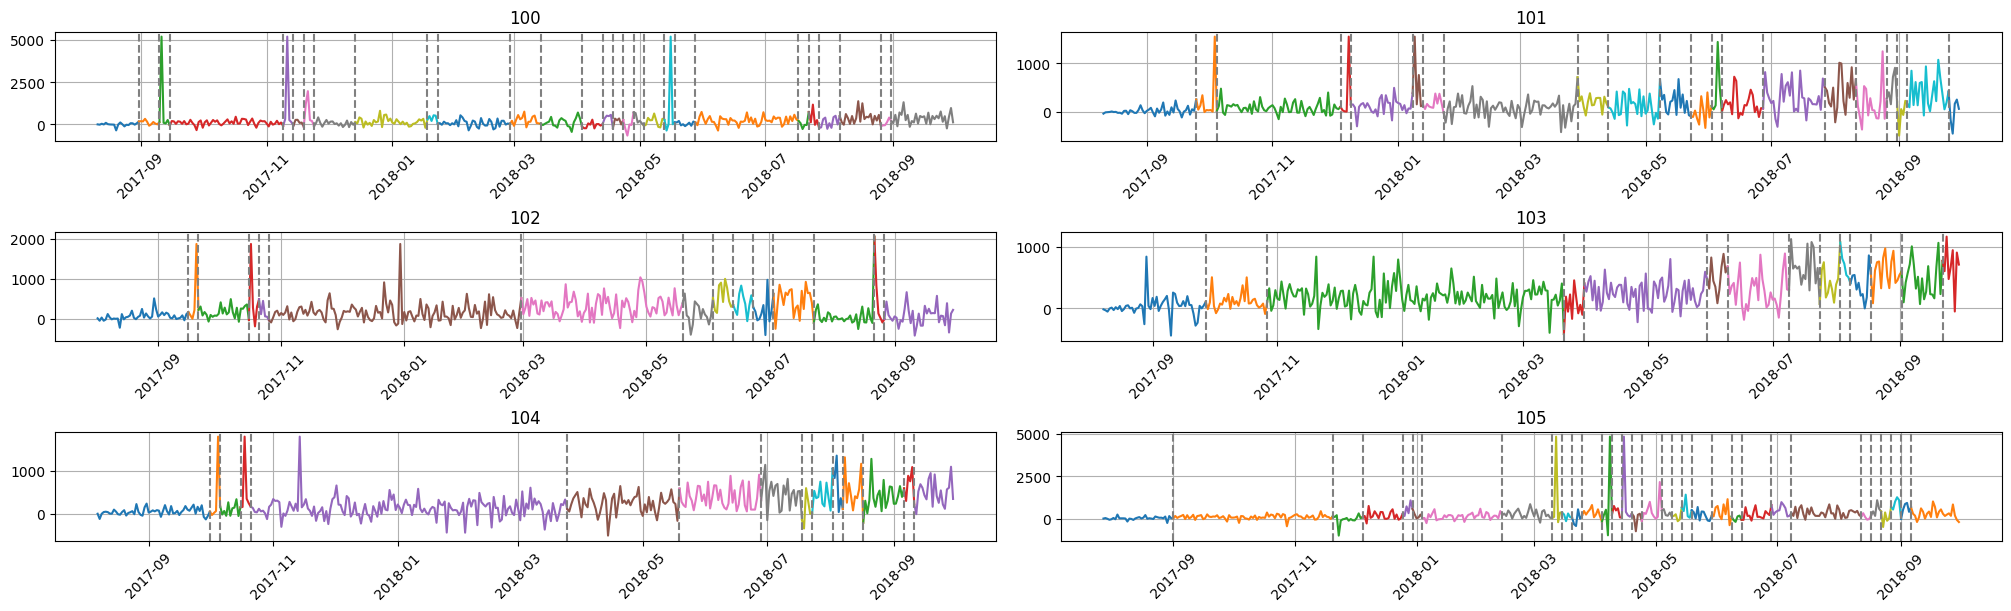

In [20]:
set_random_seed()
etna.analysis.plot_time_series_with_change_points(
    ts_nona, segments = SEGMENTS, figsize = (10, 2),
    change_points = etna.analysis.find_change_points(ts_nona, 'target', change_point_model = ruptures.detection.Binseg(), pen = 1e5)
)

Хотя общий тренд на возрастание и заметен, наблюдается большое количество локальных изменений тренда, что говорит о высокой хаотичности данных.

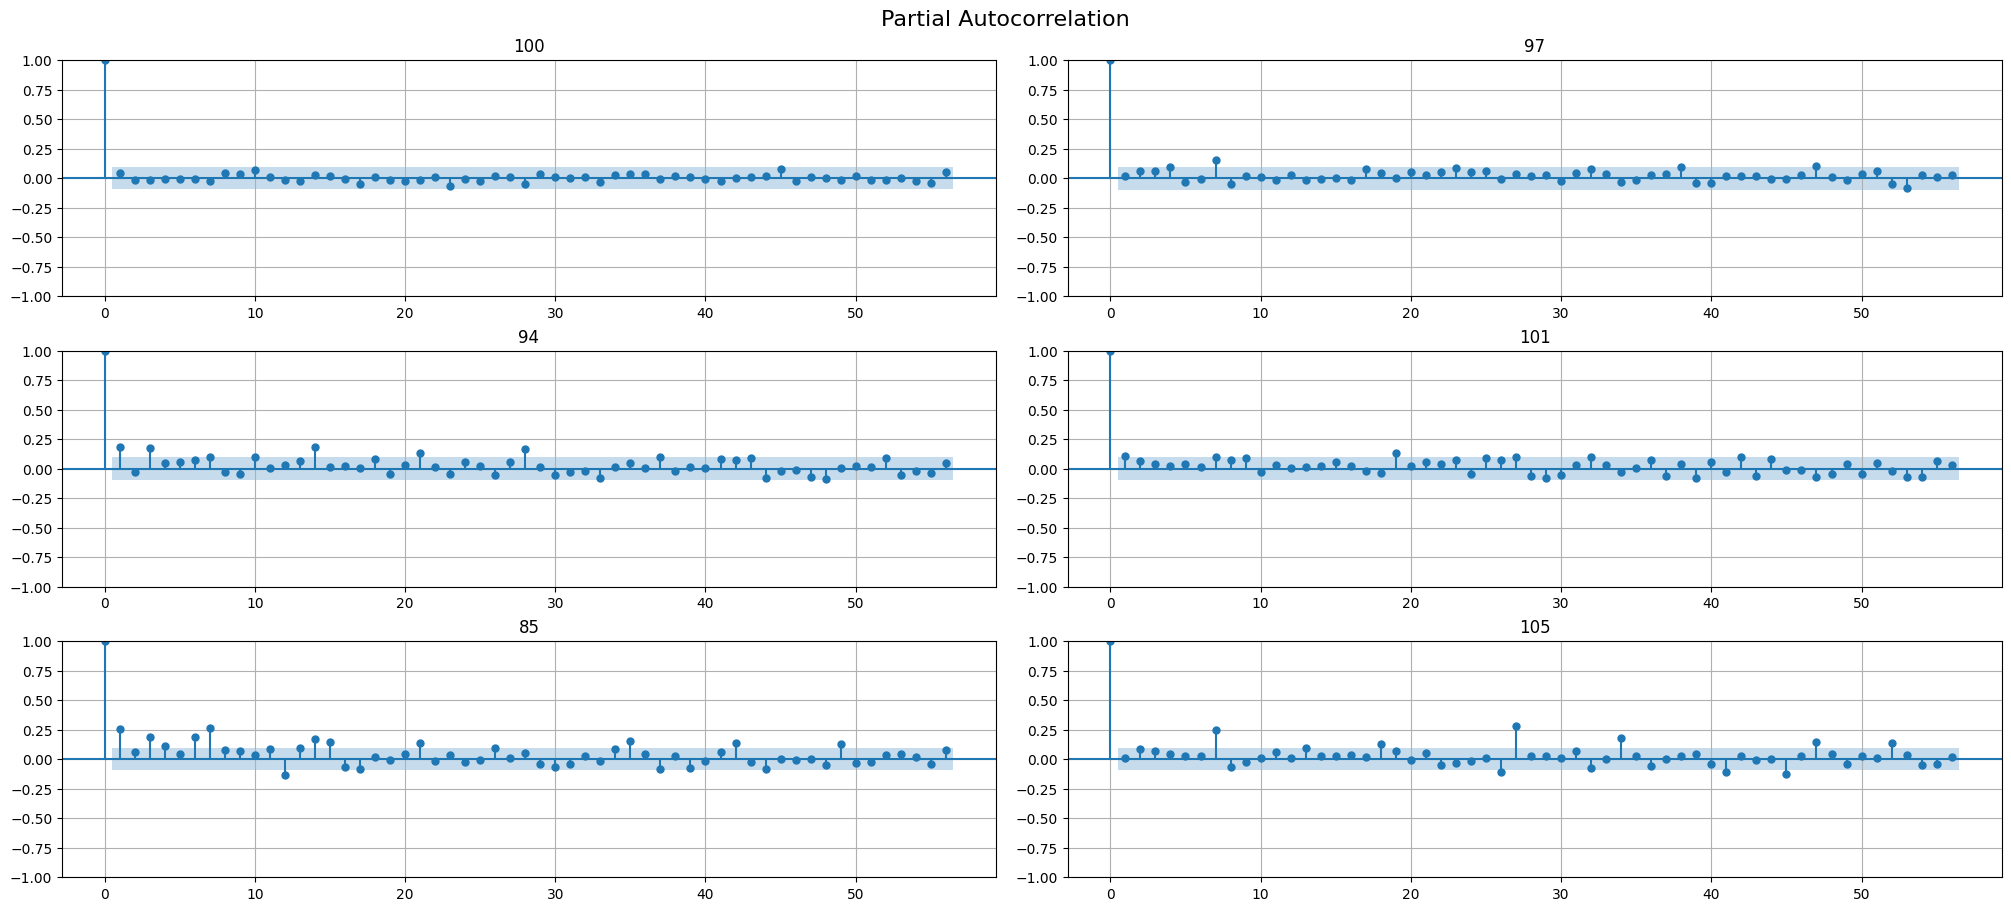

In [21]:
set_random_seed()
etna.analysis.acf_plot(ts_nona, lags = 56, partial = True, n_segments = N_SEGMENTS, figsize = (10, 3))

График частных автокорреляций также подтверждает недельную сезонность.

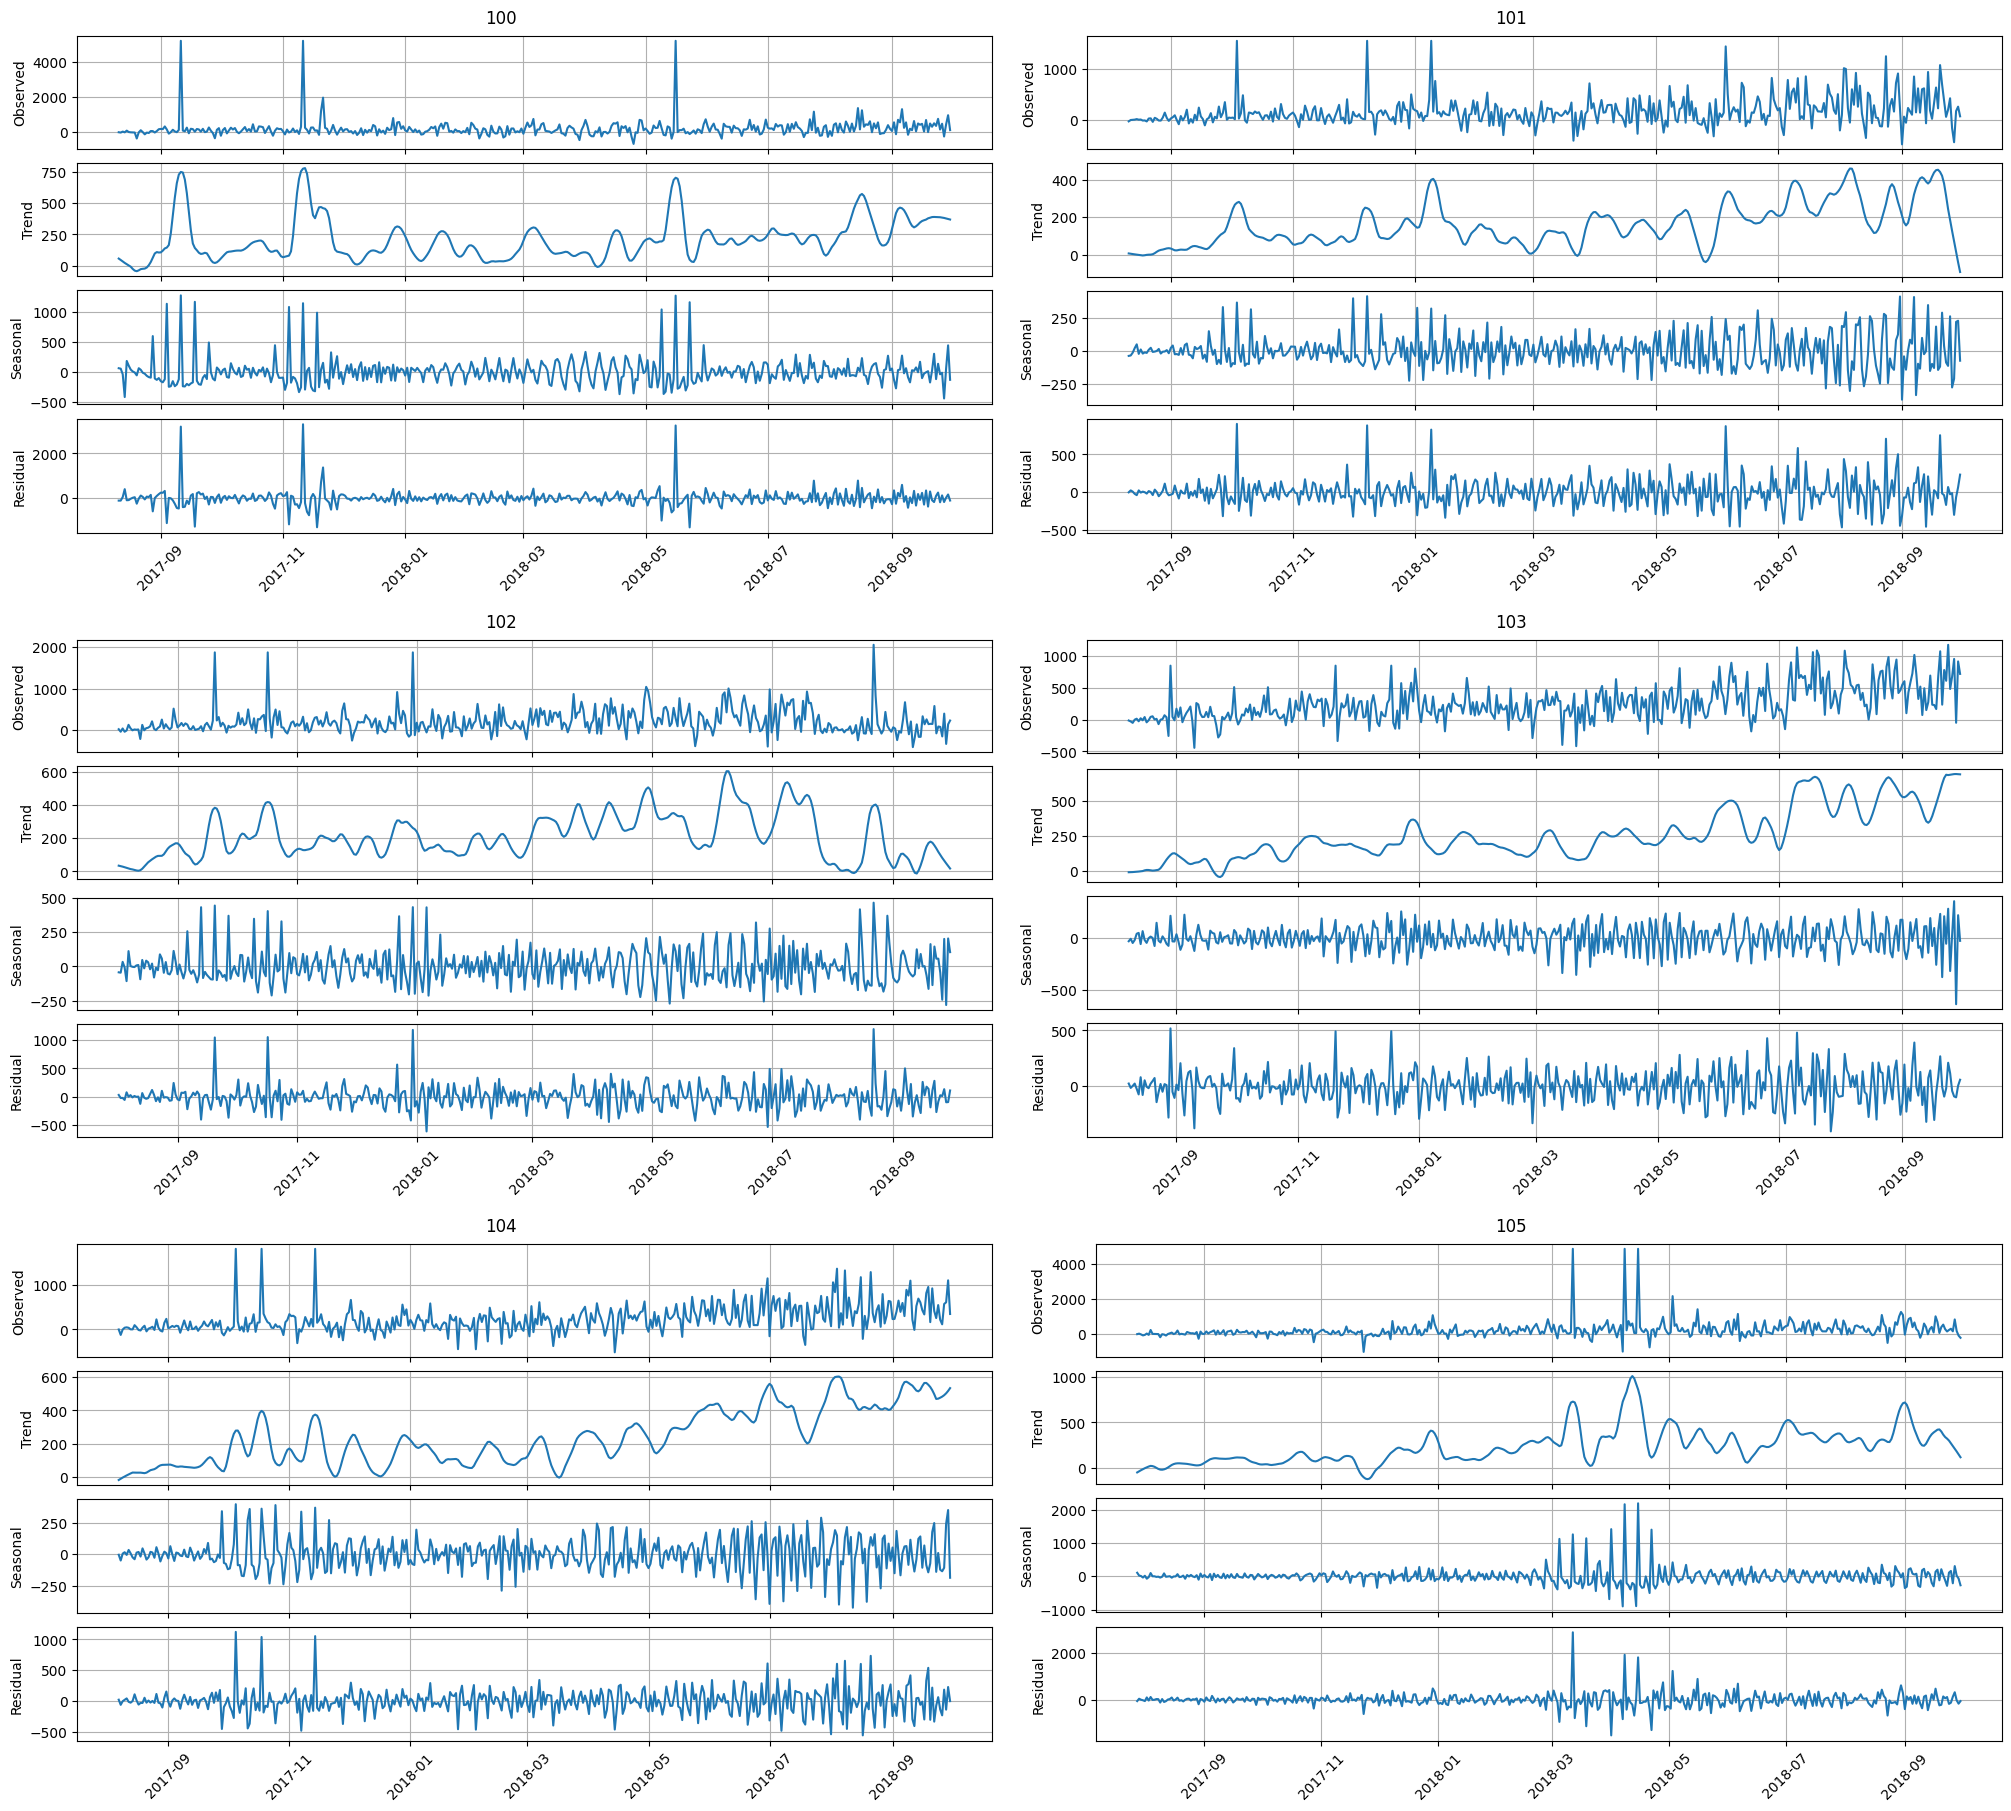

In [22]:
set_random_seed()
etna.analysis.stl_plot(ts_nona, segments = SEGMENTS, figsize = (10, 6), period = 7)

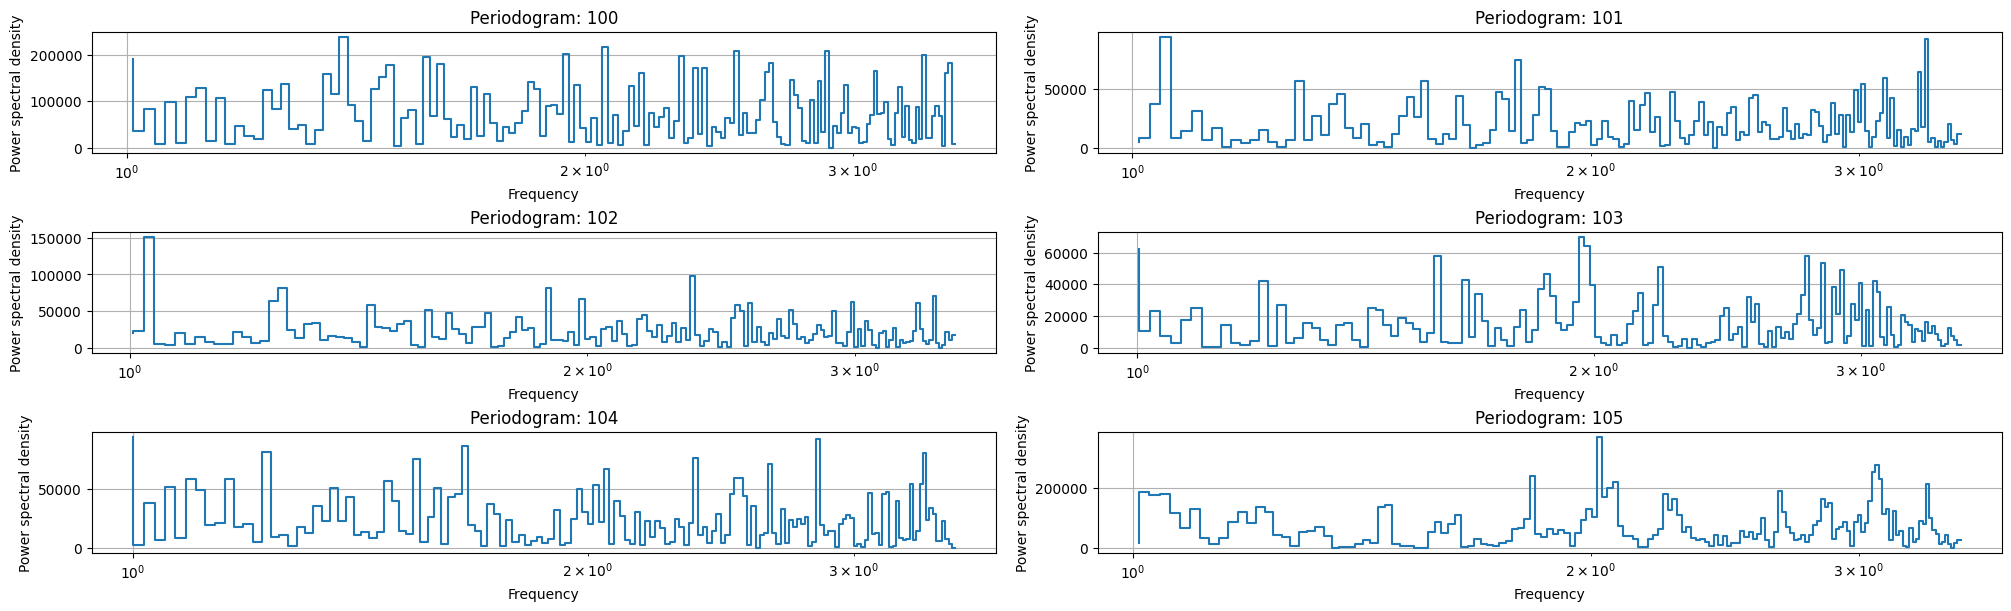

In [23]:
set_random_seed()
etna.analysis.plot_periodogram(ts_nona, period = 7, amplitude_aggregation_mode = "per-segment", segments = SEGMENTS, figsize = (10, 2))

Периоды проявляются, хотя и достаточно слабо.

Проверьте ряды на наличие выбросов, и очистите их соответствующим образом. Обоснуйте выбор.

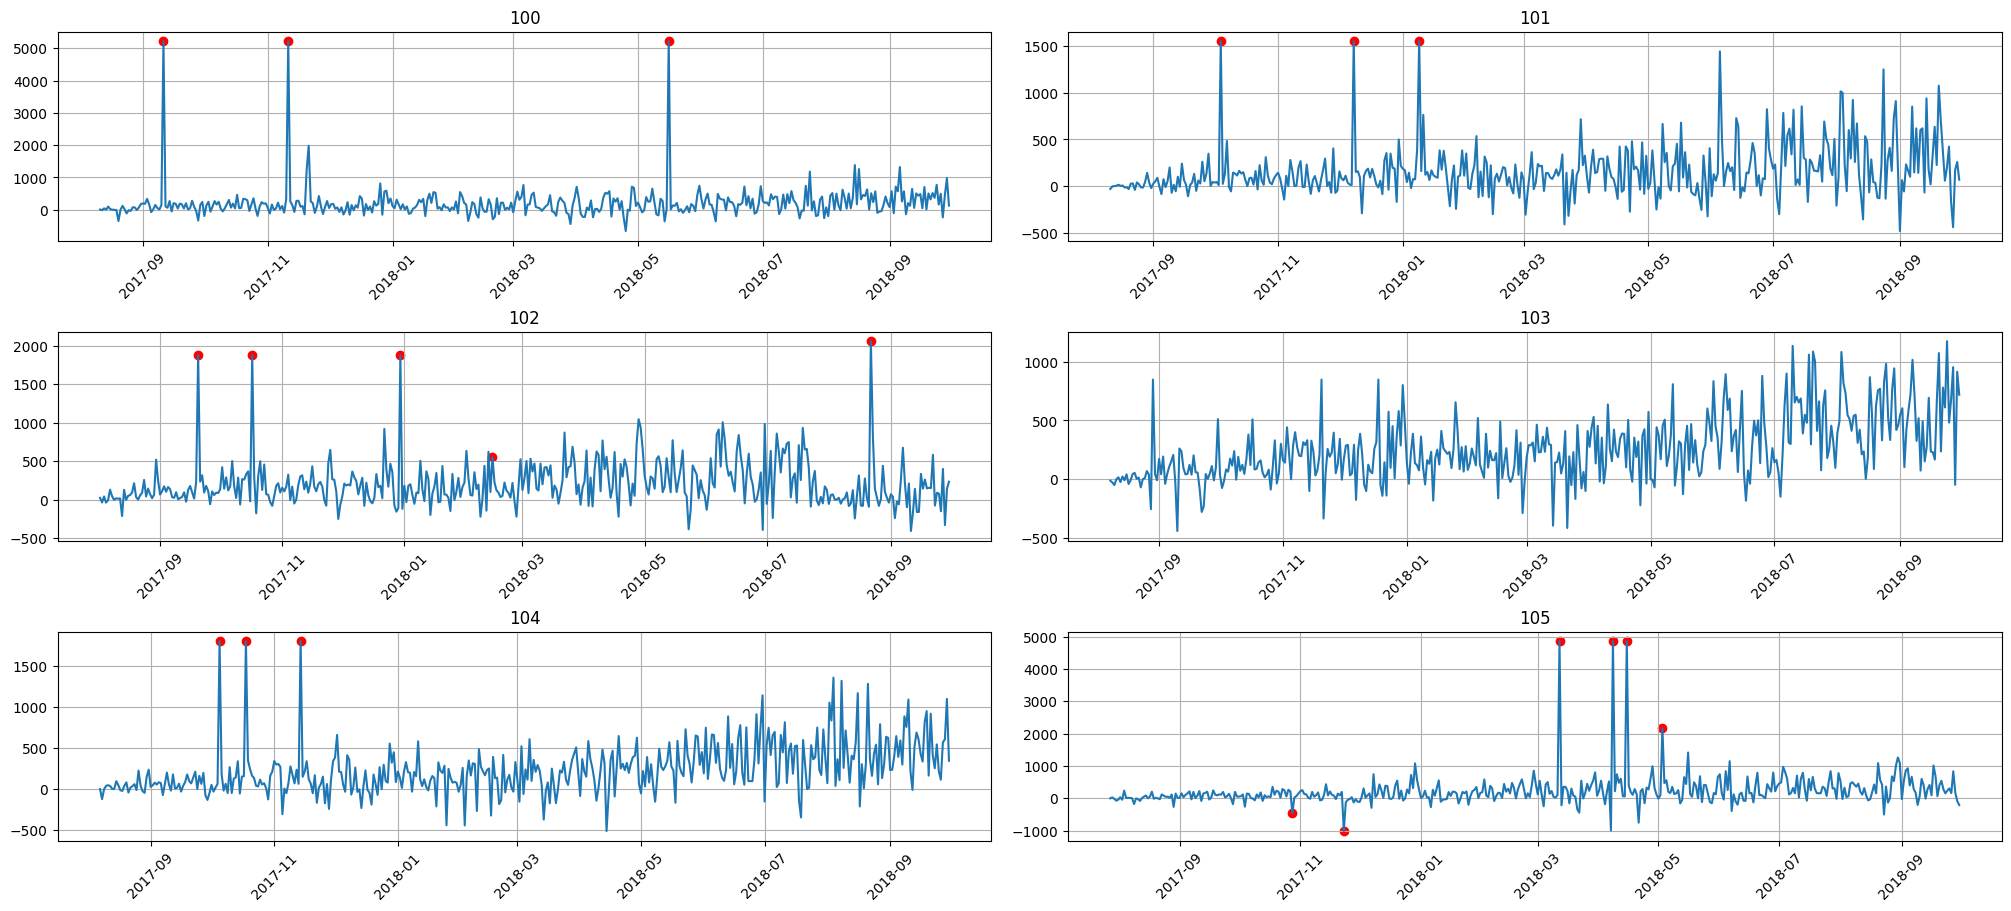

In [24]:
set_random_seed()
etna.analysis.plot_anomalies(ts_nona, etna.analysis.get_anomalies_median(ts_nona), segments = SEGMENTS, figsize = (10, 3))

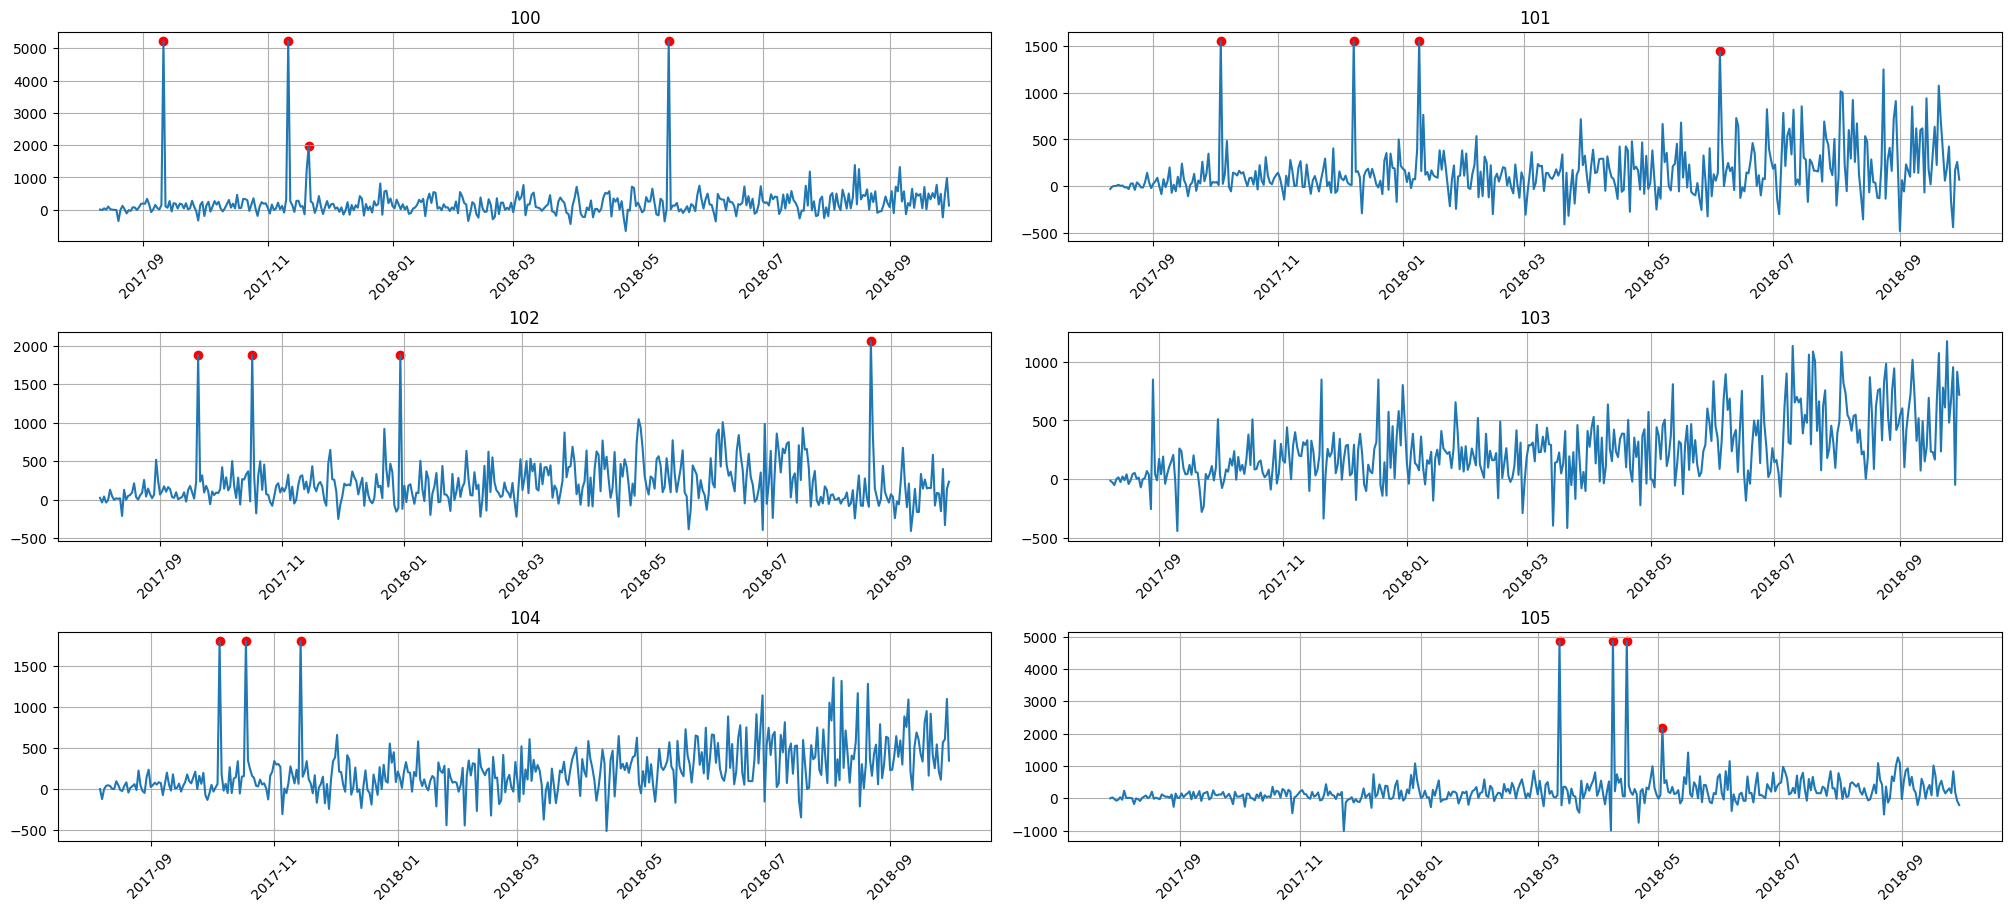

In [25]:
set_random_seed()
etna.analysis.plot_anomalies(ts_nona, etna.analysis.get_anomalies_density(ts_nona), segments = SEGMENTS, figsize = (10, 3))

В данных наблюдаются выбросы. Кажется, поиск на основе плотности точек работает неплохо при стандартных параметрах. Удалим найденные им выбросы.

In [26]:
outliers_remover = etna.transforms.DensityOutliersTransform("target")
ts_nona = outliers_remover.fit_transform(ts_nona)
ts_nona.describe()

start_timestamp end_timestamp  length  num_missing  num_segments  \
segments                                                                    
100           2017-08-11    2018-09-30     416            4            20   
101           2017-08-11    2018-09-30     416            4            20   
102           2017-08-02    2018-09-30     425            4            20   
103           2017-08-08    2018-09-30     419            0            20   
104           2017-08-07    2018-09-30     420            3            20   
105           2017-07-28    2018-09-30     430            4            20   
106           2017-08-09    2018-09-30     418            0            20   
74            2017-08-16    2018-09-30     411            3            20   
85            2017-08-03    2018-09-30     424            0            20   
86            2017-08-01    2018-09-30     426            3            20   
87            2017-06-09    2018-09-30     479            0            20   
88            2017-08-14    2018-09-30     413            3            20   
90            2017-07-27    2018-09-30     431            1            20   
91            2017-07-19    2018-09-30     439            5            20   
93            2017-08-12    2018-09-30     415            4            20   
94            2017-08-10    2018-09-30     417            3            20   
96            2017-07-28    2018-09-30     430            4            20   
97            2017-08-16    2018-09-30     411            3            20   
98            2017-08-17    2018-09-30     410            3            20   
99            2017-08-16    2018-09-30     411            2            20   

          num_exogs  num_regressors  num_known_future freq  
segments                                                    
100               0               0                 0    D  
101               0               0                 0    D  
102               0               0                 0    D  
103               0               0                 0    D  
104               0               0                 0    D  
105               0               0                 0    D  
106               0               0                 0    D  
74                0               0                 0    D  
85                0               0                 0    D  
86                0               0                 0    D  
87                0               0                 0    D  
88                0               0                 0    D  
90                0               0                 0    D  
91                0               0                 0    D  
93                0               0                 0    D  
94                0               0                 0    D  
96                0               0                 0    D  
97                0               0                 0    D  
98                0               0                 0    D  
99                0               0                 0    D

Заполним образовавшиеся пропущенные значения так же, как раньше.

In [27]:
seasonal_imputer = etna.transforms.TimeSeriesImputerTransform(strategy = 'seasonal_nonautoreg', seasonality = 7)
running_mean_imputer = etna.transforms.TimeSeriesImputerTransform(strategy = 'running_mean')
ts_nona = running_mean_imputer.fit_transform(seasonal_imputer.fit_transform(etna.datasets.TSDataset(df, freq = kFreq)))
ts_nona.describe()

start_timestamp end_timestamp  length  num_missing  num_segments  \
segments                                                                    
100           2017-08-11    2018-09-30     416            0            20   
101           2017-08-11    2018-09-30     416            0            20   
102           2017-08-02    2018-09-30     425            0            20   
103           2017-08-08    2018-09-30     419            0            20   
104           2017-08-07    2018-09-30     420            0            20   
105           2017-07-28    2018-09-30     430            0            20   
106           2017-08-09    2018-09-30     418            0            20   
74            2017-08-16    2018-09-30     411            0            20   
85            2017-08-03    2018-09-30     424            0            20   
86            2017-08-01    2018-09-30     426            0            20   
87            2017-06-09    2018-09-30     479            0            20   
88            2017-08-14    2018-09-30     413            0            20   
90            2017-07-27    2018-09-30     431            0            20   
91            2017-07-19    2018-09-30     439            0            20   
93            2017-08-12    2018-09-30     415            0            20   
94            2017-08-10    2018-09-30     417            0            20   
96            2017-07-28    2018-09-30     430            0            20   
97            2017-08-16    2018-09-30     411            0            20   
98            2017-08-17    2018-09-30     410            0            20   
99            2017-08-16    2018-09-30     411            0            20   

          num_exogs  num_regressors  num_known_future freq  
segments                                                    
100               0               0                 0    D  
101               0               0                 0    D  
102               0               0                 0    D  
103               0               0                 0    D  
104               0               0                 0    D  
105               0               0                 0    D  
106               0               0                 0    D  
74                0               0                 0    D  
85                0               0                 0    D  
86                0               0                 0    D  
87                0               0                 0    D  
88                0               0                 0    D  
90                0               0                 0    D  
91                0               0                 0    D  
93                0               0                 0    D  
94                0               0                 0    D  
96                0               0                 0    D  
97                0               0                 0    D  
98                0               0                 0    D  
99                0               0                 0    D

## Задание 3. Построение Prophet (1.25 балла)

Постройте прогнозы с помощью Prophet и `etna.Pipeline`, под капотом `etna.Pipeline` обучит `ProphetModel` для каждого сегмента в отдельности. После этого оцените качество по SMAPE на кросс-валидации. В качестве горизонта предсказания возьмите 5 дней - этого же горизонта будем придерживаться и в дальнейшем.

Отрисуйте получившийся прогноз.

In [28]:
HORIZON = 5

13:11:11 - cmdstanpy - INFO - Chain [1] start processing
13:11:11 - cmdstanpy - INFO - Chain [1] done processing
13:11:11 - cmdstanpy - INFO - Chain [1] start processing
13:11:11 - cmdstanpy - INFO - Chain [1] done processing
13:11:11 - cmdstanpy - INFO - Chain [1] start processing
13:11:11 - cmdstanpy - INFO - Chain [1] done processing
13:11:11 - cmdstanpy - INFO - Chain [1] start processing
13:11:11 - cmdstanpy - INFO - Chain [1] done processing
13:11:11 - cmdstanpy - INFO - Chain [1] start processing
13:11:12 - cmdstanpy - INFO - Chain [1] done processing
13:11:12 - cmdstanpy - INFO - Chain [1] start processing
13:11:12 - cmdstanpy - INFO - Chain [1] done processing
13:11:12 - cmdstanpy - INFO - Chain [1] start processing
13:11:12 - cmdstanpy - INFO - Chain [1] done processing
13:11:12 - cmdstanpy - INFO - Chain [1] start processing
13:11:12 - cmdstanpy - INFO - Chain [1] done processing
13:11:12 - cmdstanpy - INFO - Chain [1] start processing
13:11:12 - cmdstanpy - INFO - Chain [1]

segment       SMAPE
0      100   86.092972
1      101   85.632653
2      102   98.978884
3      103   59.450095
4      104   53.314929
5      105   85.142295
6      106   85.994370
7       74   54.631994
8       85   55.546799
9       86   66.908790
10      87   69.358696
11      88   75.755472
12      90   55.145191
13      91  104.023923
14      93   47.857991
15      94   56.597072
16      96  100.733680
17      97   84.808718
18      98   78.557370
19      99  108.814939

Average SMAPE:  75.66734166862602


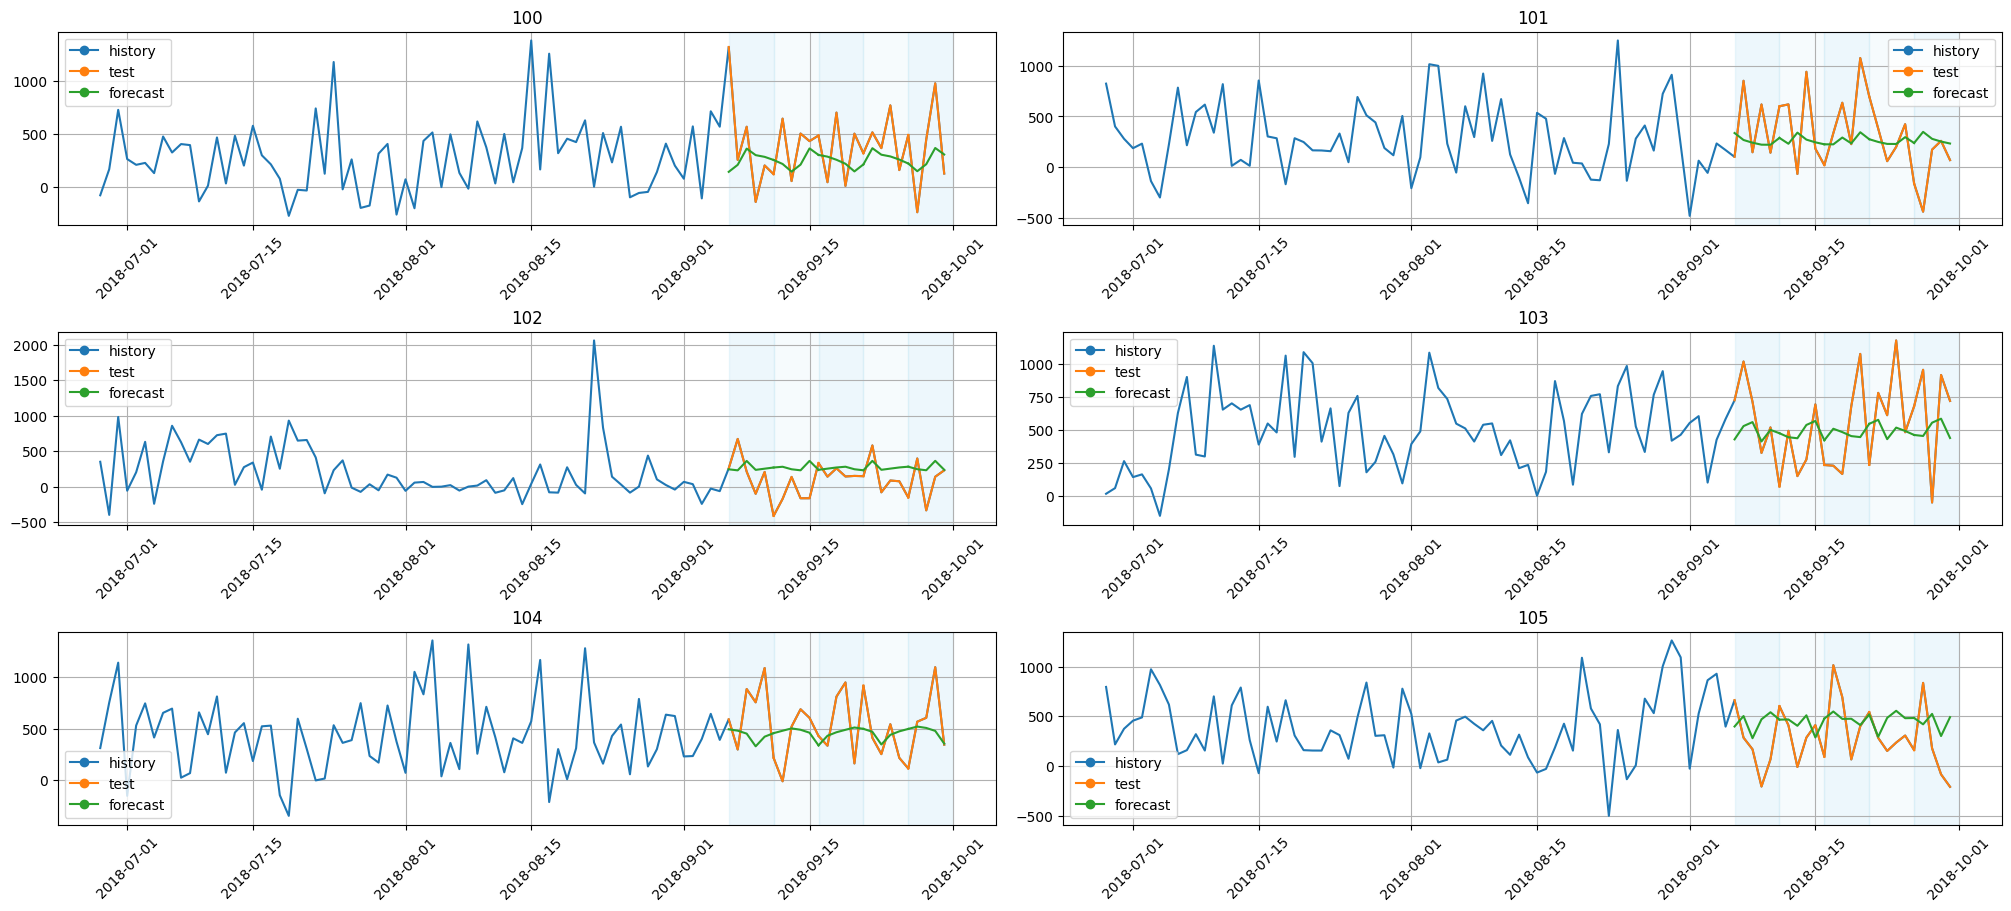

In [48]:
set_random_seed()
pipeline = etna.pipeline.Pipeline(model = etna.models.ProphetModel(), horizon = HORIZON)
metrics_df, forecast_df, fold_info_df = pipeline.backtest(ts_nona, metrics = [ etna.metrics.SMAPE() ], aggregate_metrics = True, refit = False)
display(metrics_df)
print("Average SMAPE: ", metrics_df[["SMAPE"]].mean().item())
etna.analysis.plot_backtest(forecast_df, ts_nona, history_len = 70, segments = SEGMENTS, figsize = (10, 3))

Исходя из статистики по каждому ряду, какой можно сделать вывод о том, как лучше предсказывать итоговое значение? Посчитайте то же самое исходя из MAE.

Результаты получились достаточно плохие, точные выводы сделать может быть сложно. Видно, что для некоторых банкоматов результат был предсказан относительно хорошо (ошибка чуть более 50%), но для других ошибка превысила 100%. Использование таких прогнозов может привести к излишним расходам. \
Попыткой невелирования этой проблемы может быть предсказание одного числа - общего количества средств в банкоматах - с дальнейшим пропорциональным разделением по каждому отдельному банкомату. Потенциальную эффективность такого подхода подтверждают и замеченные ранее корреляции между данными различных банкоматов. Общее количество выданных банкнот должно быть относительно стационарно в рассматриваемый период времени.

13:10:20 - cmdstanpy - INFO - Chain [1] start processing
13:10:20 - cmdstanpy - INFO - Chain [1] done processing
13:10:20 - cmdstanpy - INFO - Chain [1] start processing
13:10:20 - cmdstanpy - INFO - Chain [1] done processing
13:10:20 - cmdstanpy - INFO - Chain [1] start processing
13:10:20 - cmdstanpy - INFO - Chain [1] done processing
13:10:20 - cmdstanpy - INFO - Chain [1] start processing
13:10:20 - cmdstanpy - INFO - Chain [1] done processing
13:10:20 - cmdstanpy - INFO - Chain [1] start processing
13:10:20 - cmdstanpy - INFO - Chain [1] done processing
13:10:21 - cmdstanpy - INFO - Chain [1] start processing
13:10:21 - cmdstanpy - INFO - Chain [1] done processing
13:10:21 - cmdstanpy - INFO - Chain [1] start processing
13:10:21 - cmdstanpy - INFO - Chain [1] done processing
13:10:21 - cmdstanpy - INFO - Chain [1] start processing
13:10:21 - cmdstanpy - INFO - Chain [1] done processing
13:10:21 - cmdstanpy - INFO - Chain [1] start processing
13:10:21 - cmdstanpy - INFO - Chain [1]

segment         MAE
0      100  276.631481
1      101  281.750208
2      102  223.209674
3      103  281.654715
4      104  252.853779
5      105  278.561516
6      106   73.930416
7       74  569.444885
8       85  261.032649
9       86  165.444434
10      87  309.321218
11      88  296.246186
12      90  208.103654
13      91  308.458420
14      93  322.001898
15      94  193.242296
16      96  185.801414
17      97  270.644368
18      98  213.278293
19      99  322.671976

Average MAE:  264.7141740419721


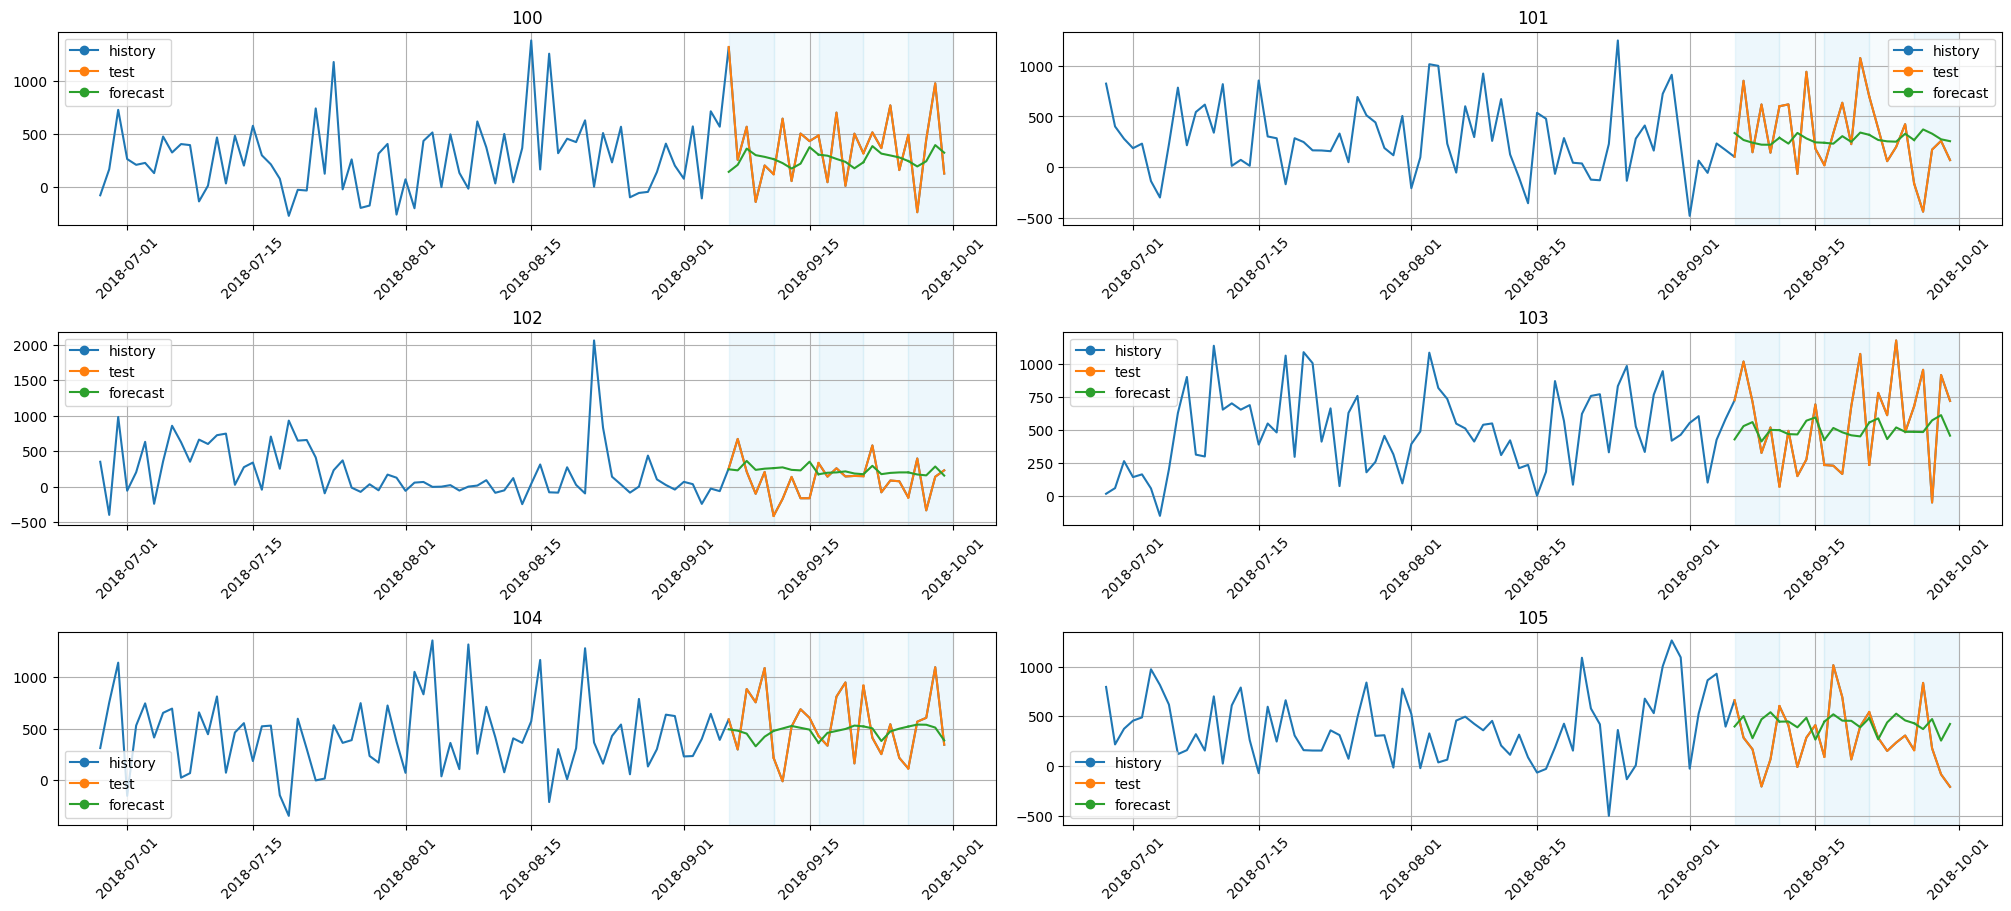

In [47]:
set_random_seed()
pipeline = etna.pipeline.Pipeline(model = etna.models.ProphetModel(), horizon = HORIZON)
metrics_df, forecast_df, fold_info_df = pipeline.backtest(ts_nona, metrics = [ etna.metrics.MAE() ], aggregate_metrics = True)
display(metrics_df)
print("Average MAE: ", metrics_df[["MAE"]].mean().item())
etna.analysis.plot_backtest(forecast_df, ts_nona, history_len = 70, segments = SEGMENTS, figsize = (10, 3))

В результатах по MAE наблюдаются схожие закономерности.

## Задание 4. Иерархический временной ряд (2 балла)

Вопрос, поставленный в прошлом задании, тем не менее, естественным образом подводит нас к концепции **иерархического временного ряда** (когда один ряд состоит из других в качестве компонент). Это полезная концепция, которая может встретиться во многих задачах. В этом задании вам предстоит самостоятельно разобраться в деталях ее реализации в ETNA с использованием справочных материалов, предоставляемых библиотекой (как это часто бывает на практике). Они содержатся по следующей ссылке: https://github.com/etna-team/etna/blob/master/examples/303-hierarchical_pipeline.ipynb

На выходе из первой части задания необходимо получить `TSDataset` с иерархической структурой, а также соответствующий реконсилятор, который позволит собирать искомый ряд из составных компонент. Классы, которые вам понадобятся, импортированы ниже.

TopDownReconciliator библиотеки ETNA не поддерживает отрицательные значения целевой переменной. Так как использование других реализаций запрещено в настоящей работе, приведём значения к положительным "сдвигом" множества значений на 10000 - оценка максимального изменения количества средств в банкомате за сутки в течение изучаемого периода. Для этого прибавим 10000 ко всем значениям целевой переменной.

In [31]:
df[["target"]].abs().max()

target    8814.9103
dtype: float64

In [32]:
hierarchical_df = df.copy().rename(columns = { 'segment': 'atm' })
hierarchical_df[["target"]] += 10000

hierarchical_df, hierarchical_structure = etna.datasets.TSDataset.to_hierarchical_dataset(
    df = hierarchical_df, level_columns = ["atm"]
)
print(hierarchical_structure)

hierarchical_ts = etna.datasets.TSDataset(df = hierarchical_df, freq = kFreq, hierarchical_structure = hierarchical_structure)
display(hierarchical_ts)

HierarchicalStructure(level_structure = {'total': ['74', '85', '86', '87', '88', '90', '91', '93', '94', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106']}, level_names = ['total', 'atm'], )


segment              100           101           102           103  \
feature           target        target        target        target   
timestamp                                                            
2017-06-09           NaN           NaN           NaN           NaN   
2017-06-10           NaN           NaN           NaN           NaN   
2017-06-11           NaN           NaN           NaN           NaN   
2017-06-12           NaN           NaN           NaN           NaN   
2017-06-13           NaN           NaN           NaN           NaN   
...                  ...           ...           ...           ...   
2018-09-26  10489.428602   9838.553575   9848.349796  10677.704316   
2018-09-27   9760.507408   9561.199914  10398.467898  10953.351729   
2018-09-28  10447.007730  10172.448787   9667.575693   9949.989263   
2018-09-29  10976.797939  10258.761434  10140.942023  10914.431608   
2018-09-30  10125.791711  10069.338415  10231.490874  10718.065922   

segment              104           105           106            74  \
feature           target        target        target        target   
timestamp                                                            
2017-06-09           NaN           NaN           NaN           NaN   
2017-06-10           NaN           NaN           NaN           NaN   
2017-06-11           NaN           NaN           NaN           NaN   
2017-06-12           NaN           NaN           NaN           NaN   
2017-06-13           NaN           NaN           NaN           NaN   
...                  ...           ...           ...           ...   
2018-09-26  10114.818767  10160.505046  10002.794718  12297.228473   
2018-09-27  10568.916255  10836.297187   9893.212368  11693.304703   
2018-09-28  10606.659652  10178.891346  10153.091690  10937.613056   
2018-09-29  11097.500322   9917.011595  10049.775392  10553.560017   
2018-09-30  10345.633026   9791.484647   9999.705819  10300.917543   

segment               85            86            87            88  \
feature           target        target        target        target   
timestamp                                                            
2017-06-09           NaN           NaN  10000.617780           NaN   
2017-06-10           NaN           NaN  10001.441486           NaN   
2017-06-11           NaN           NaN   9999.764655           NaN   
2017-06-12           NaN           NaN   9986.467683           NaN   
2017-06-13           NaN           NaN  10007.398647           NaN   
...                  ...           ...           ...           ...   
2018-09-26  10348.074726  10120.378785  10430.162938  10511.345072   
2018-09-27  10846.975950  10367.520077  10420.081361  10382.935151   
2018-09-28  10557.207859  10209.133133  10293.298261  10530.084389   
2018-09-29  10489.163839  10123.820700  10231.049603  10580.889414   
2018-09-30  10306.448143  10150.532317  10108.611553  10560.414430   

segment               90            91            93            94  \
feature           target        target        target        target   
timestamp                                                            
2017-06-09           NaN           NaN           NaN           NaN   
2017-06-10           NaN           NaN           NaN           NaN   
2017-06-11           NaN           NaN           NaN           NaN   
2017-06-12           NaN           NaN           NaN           NaN   
2017-06-13           NaN           NaN           NaN           NaN   
...                  ...           ...           ...           ...   
2018-09-26  10069.338415  10243.022761  10844.916685  10517.022761   
2018-09-27  10351.575478  10374.727507  10199.748765  10753.397037   
2018-09-28  10536.821129  10179.420872  11364.028130  10280.413142   
2018-09-29  10395.908525  10093.372987  10916.108439  10463.364183   
2018-09-30  10501.695942  10084.312218  10935.583208  10123.644192   

segment               96            97            98            99  
feature

In [33]:
ahp_reconciliator = etna.reconciliation.TopDownReconciliator(
    target_level = "atm", source_level = "total", method = "AHP", period = 7
)
ahp_reconciliator.fit(hierarchical_ts)

TopDownReconciliator(target_level = 'atm', source_level = 'total', period = 7, method = 'AHP', )

In [34]:
pha_reconciliator = etna.reconciliation.TopDownReconciliator(
    target_level = "atm", source_level = "total", method = "PHA", period = 7
)
pha_reconciliator.fit(hierarchical_ts)

TopDownReconciliator(target_level = 'atm', source_level = 'total', period = 7, method = 'PHA', )

Во второй части задания примените найденные на предыдущих этапах преобразования очистку от выбросов уже к иерархическому датасету, и запустите на нем Prophet с MAE на кросс-валидации.

In [35]:
hierarchical_outliers_remover = etna.transforms.DensityOutliersTransform("target")
hierarchical_ts_nona = hierarchical_outliers_remover.fit_transform(hierarchical_ts)
hierarchical_ts_nona.hierarchical_structure

HierarchicalStructure(level_structure = {'total': ['74', '85', '86', '87', '88', '90', '91', '93', '94', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106']}, level_names = ['total', 'atm'], )

In [36]:
hierarchical_seasonal_imputer = etna.transforms.TimeSeriesImputerTransform(strategy = 'seasonal_nonautoreg', seasonality = 7)
hierarchical_running_mean_imputer = etna.transforms.TimeSeriesImputerTransform(strategy = 'running_mean')
hierarchical_ts_nona = hierarchical_running_mean_imputer.fit_transform(
    hierarchical_seasonal_imputer.fit_transform(
        etna.datasets.TSDataset(df = hierarchical_df, freq = kFreq, hierarchical_structure = hierarchical_structure)
    )
)
hierarchical_ts_nona.hierarchical_structure

HierarchicalStructure(level_structure = {'total': ['74', '85', '86', '87', '88', '90', '91', '93', '94', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106']}, level_names = ['total', 'atm'], )

In [37]:
hierarchical_ts_nona_total = hierarchical_ts_nona.get_level_dataset("total")

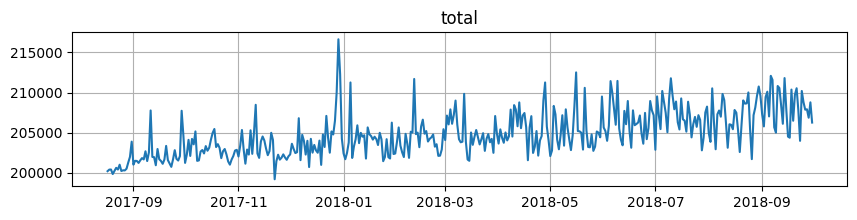

In [38]:
hierarchical_ts_nona_total.plot(figsize = (10, 2))

Ряд общего количества выданной наличности не стационарен.

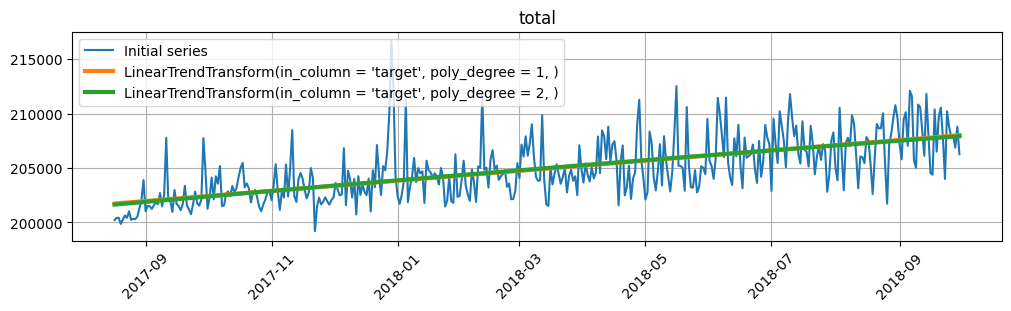

In [39]:
set_random_seed()
etna.analysis.plot_trend(hierarchical_ts_nona_total, figsize = (10, 3), trend_transform = [
    etna.transforms.LinearTrendTransform(in_column = "target", poly_degree = 1),
    etna.transforms.LinearTrendTransform(in_column = "target", poly_degree = 2),
])

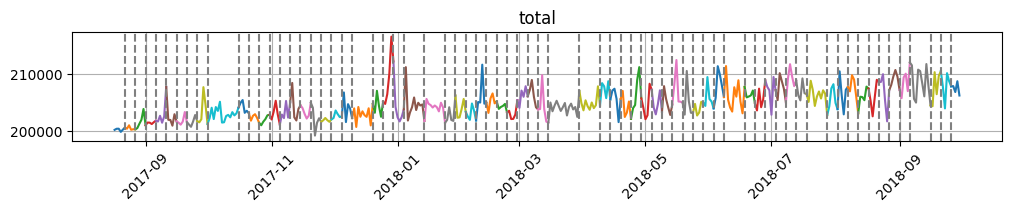

In [40]:
set_random_seed()
etna.analysis.plot_time_series_with_change_points(
    hierarchical_ts_nona_total, figsize = (10, 2),
    change_points = etna.analysis.find_change_points(hierarchical_ts_nona_total, 'target', change_point_model = ruptures.detection.Binseg(), pen = 1e5)
)

В нём также наблюдается возрастающий тренд, хотя и с большим количеством локальных точек перегиба

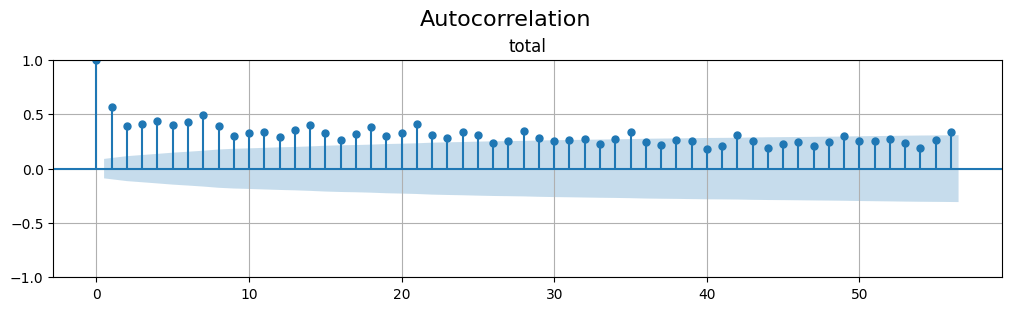

In [41]:
set_random_seed()
etna.analysis.acf_plot(hierarchical_ts_nona_total, lags = 56, figsize = (10, 3))

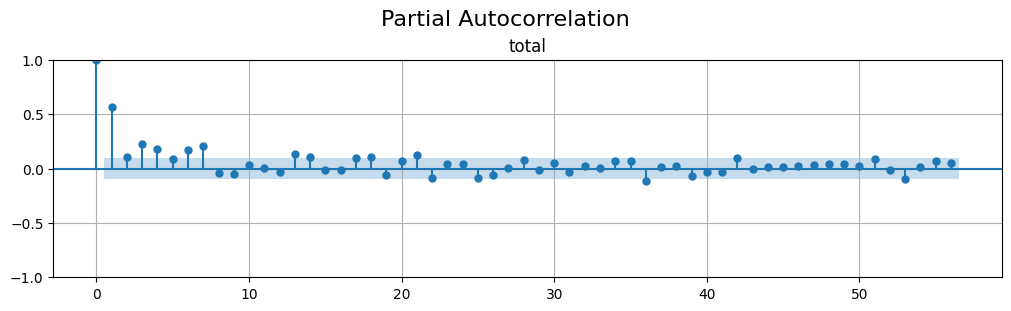

In [42]:
set_random_seed()
etna.analysis.acf_plot(hierarchical_ts_nona_total, lags = 56, partial = True, figsize = (10, 3))

Недельная сезонность также проявляется.

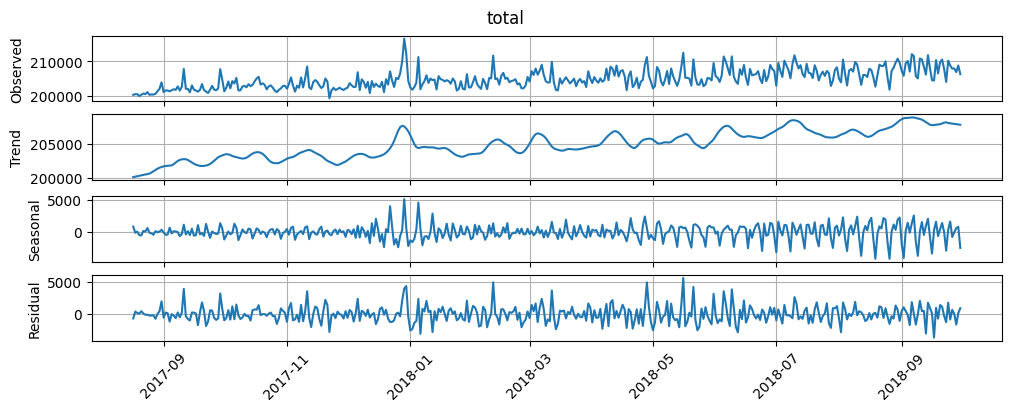

In [43]:
set_random_seed()
etna.analysis.stl_plot(hierarchical_ts_nona_total, figsize = (10, 4), period = 7)

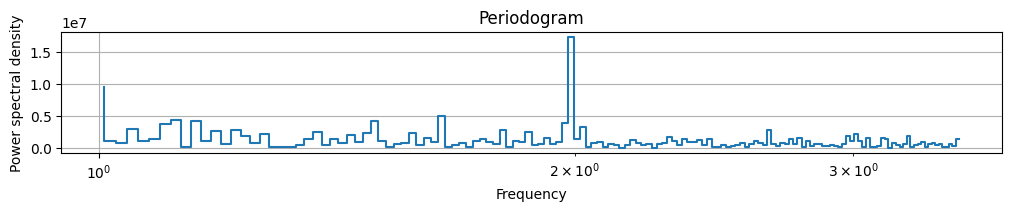

In [44]:
set_random_seed()
etna.analysis.plot_periodogram(hierarchical_ts_nona_total, period = 7, figsize = (10, 2))

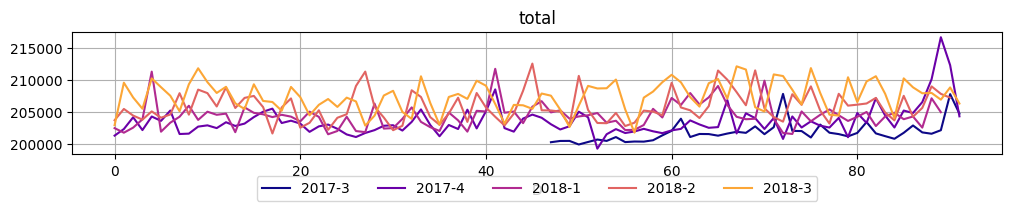

In [45]:
set_random_seed()
etna.analysis.seasonal_plot(hierarchical_ts_nona_total, figsize = (10, 2), cycle = "quarter")

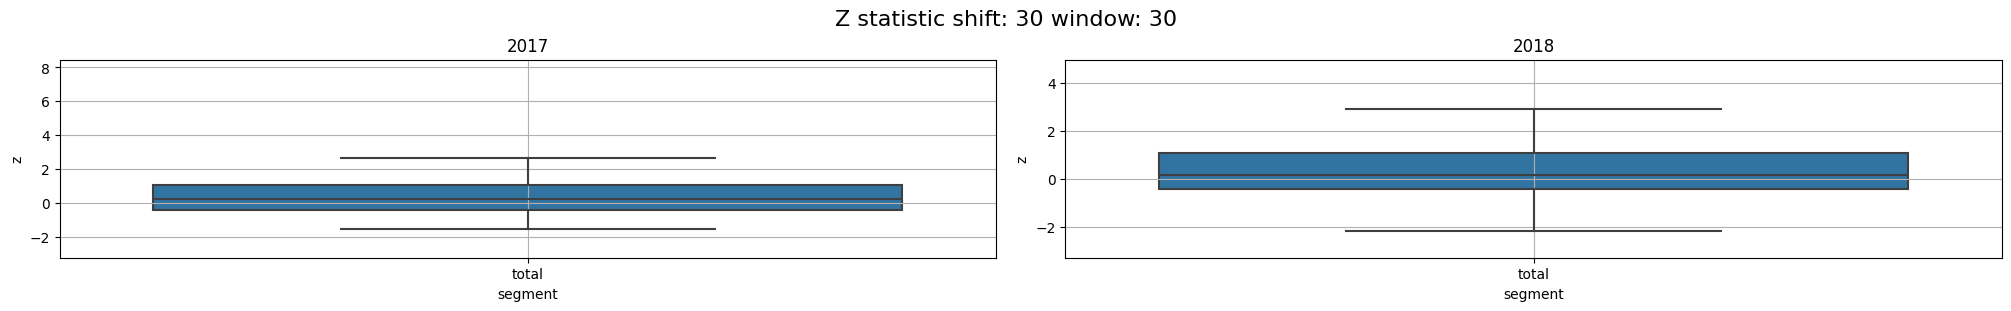

In [46]:
set_random_seed()
etna.analysis.distribution_plot(hierarchical_ts_nona_total, figsize = (10, 3), freq = "1Y")

13:28:35 - cmdstanpy - INFO - Chain [1] start processing
13:28:35 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
13:28:35 - cmdstanpy - INFO - Chain [1] start processing
13:28:35 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.2s
13:28:35 - cmdstanpy - INFO - Chain [1] start processing
13:28:35 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.4s
13:28:35 - cmdstanpy - INFO - Chain [1] start processing
13:28:35 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.6s
13:28:35 - cmdstanpy - INFO - Chain [1] start processing
13:28:35 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Paralle

segment         MAE
0      100  270.276199
1      101  310.638187
2      102  267.500821
3      103  281.303125
4      104  265.854136
5      105  293.107242
6      106   70.476497
7       74  741.879826
8       85  307.840652
9       86  178.071011
10      87  380.982667
11      88  333.249487
12      90  200.222008
13      91  319.904904
14      93  349.648039
15      94  200.286648
16      96  178.173389
17      97  333.298544
18      98  235.073331
19      99  363.924733

Average MAE:  294.0855722432994


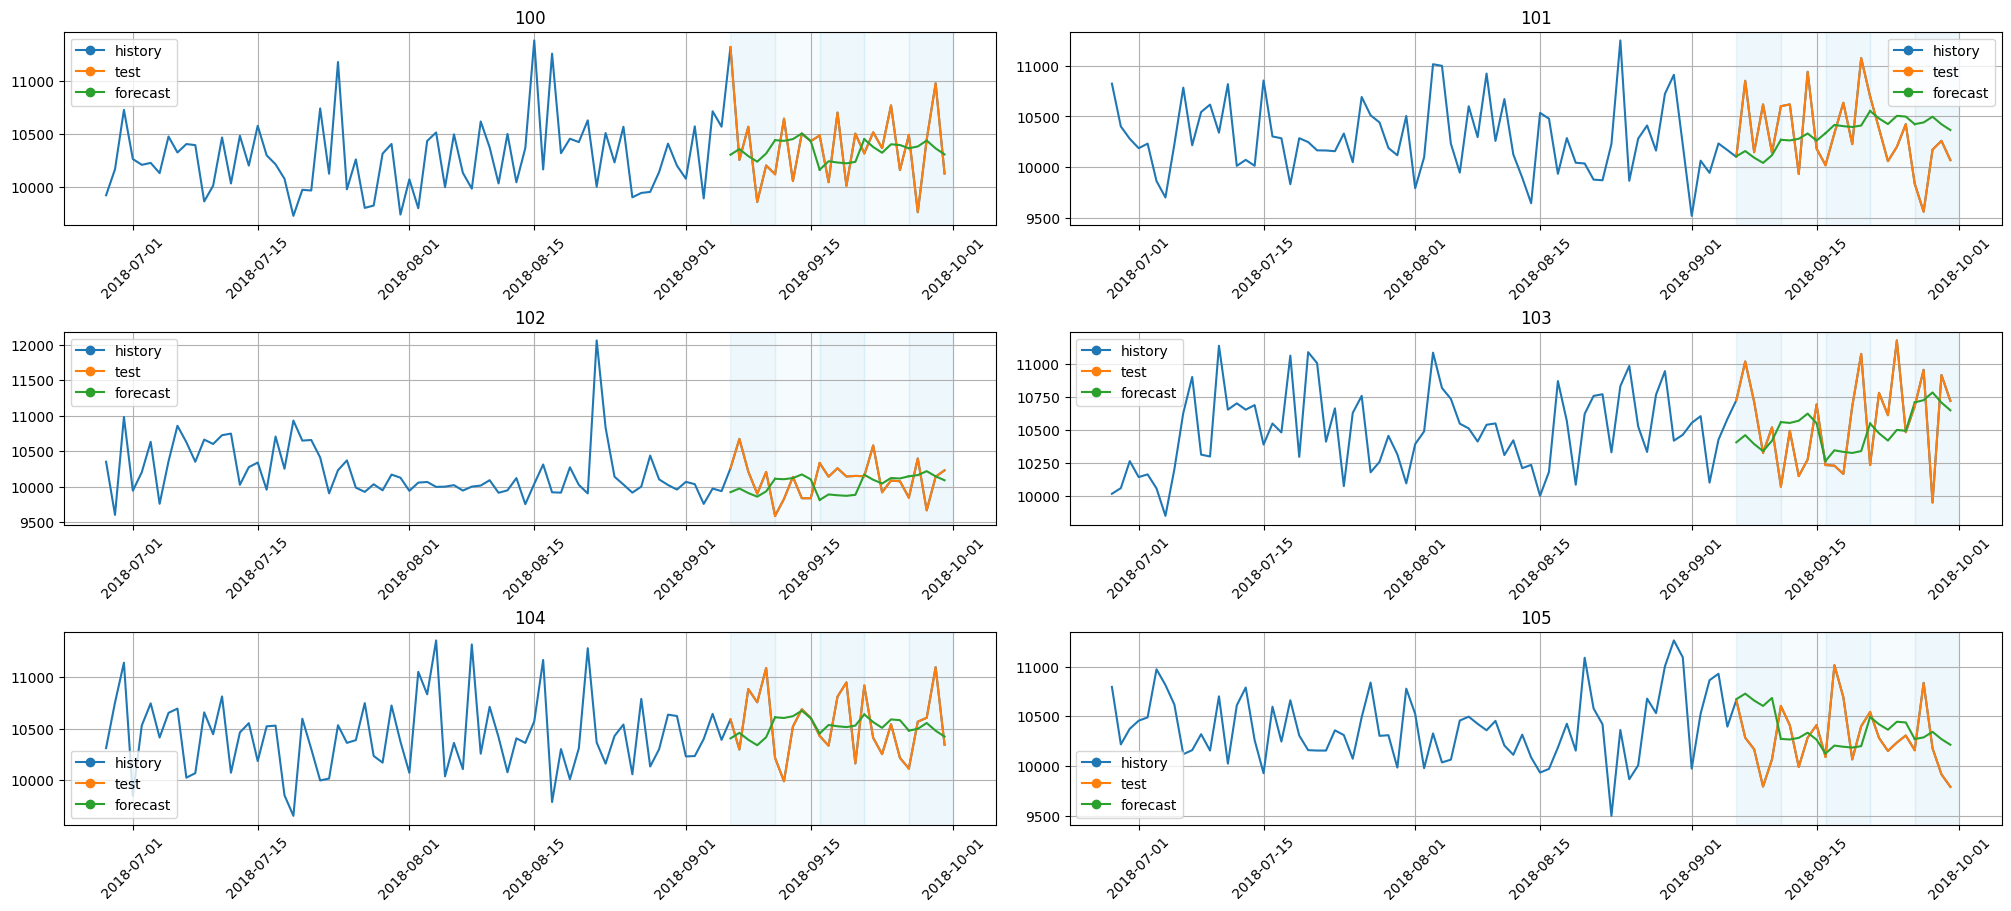

In [54]:
set_random_seed()
hierarchical_pipeline = etna.pipeline.HierarchicalPipeline(model = etna.models.ProphetModel(), reconciliator = ahp_reconciliator, horizon = HORIZON)
ahp_metrics_df, ahp_forecast_df, ahp_fold_info_df = hierarchical_pipeline.backtest(hierarchical_ts_nona, metrics = [ etna.metrics.MAE() ], aggregate_metrics = True)
display(ahp_metrics_df)
print("Average MAE: ", ahp_metrics_df[["MAE"]].mean().item())
etna.analysis.plot_backtest(ahp_forecast_df, hierarchical_ts_nona, history_len = 70, segments = SEGMENTS, figsize = (10, 3))

13:28:44 - cmdstanpy - INFO - Chain [1] start processing
13:28:44 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
13:28:44 - cmdstanpy - INFO - Chain [1] start processing
13:28:44 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.2s
13:28:44 - cmdstanpy - INFO - Chain [1] start processing
13:28:44 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.4s
13:28:44 - cmdstanpy - INFO - Chain [1] start processing
13:28:44 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.5s
13:28:45 - cmdstanpy - INFO - Chain [1] start processing
13:28:45 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Paralle

segment         MAE
0      100  270.326997
1      101  311.025142
2      102  267.691869
3      103  281.440264
4      104  265.555808
5      105  293.218613
6      106   70.362394
7       74  743.067339
8       85  308.122540
9       86  178.191692
10      87  380.961547
11      88  333.827166
12      90  200.178132
13      91  320.051127
14      93  349.878564
15      94  200.548546
16      96  178.082480
17      97  333.532004
18      98  235.373498
19      99  363.794524

Average MAE:  294.2615123492386


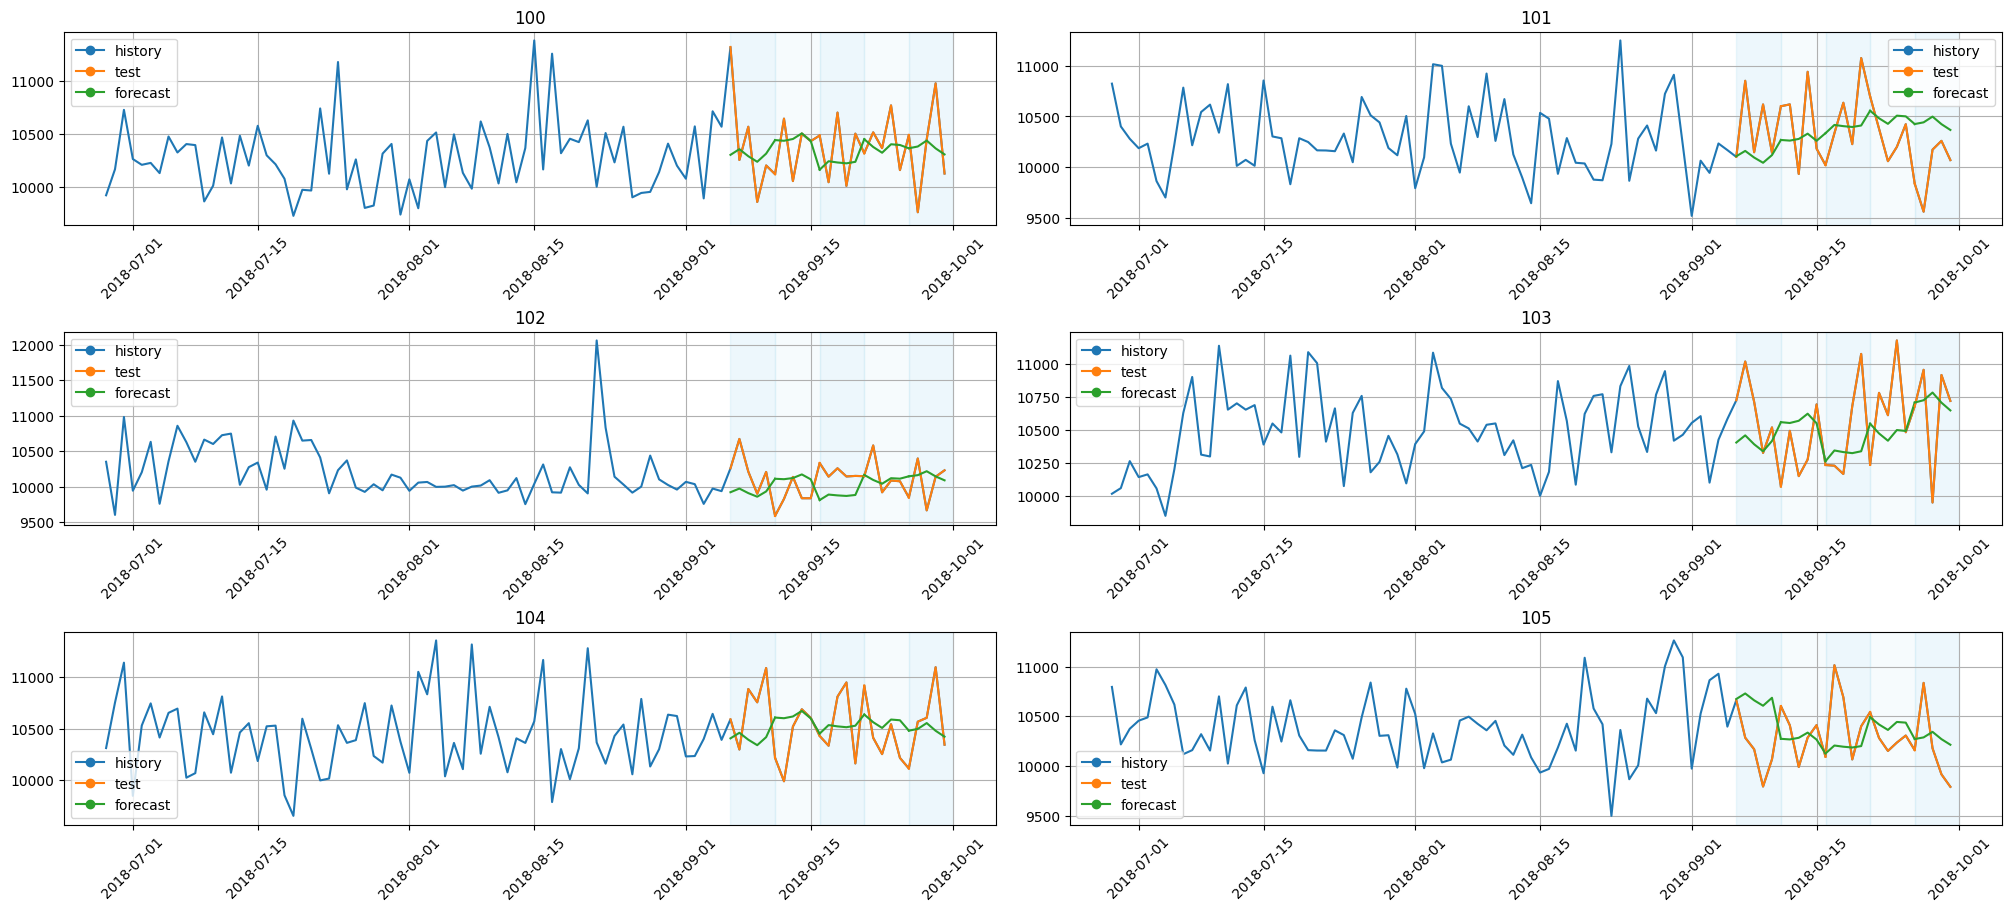

In [55]:
set_random_seed()
hierarchical_pipeline = etna.pipeline.HierarchicalPipeline(model = etna.models.ProphetModel(), reconciliator = pha_reconciliator, horizon = HORIZON)
pha_metrics_df, pha_forecast_df, pha_fold_info_df = hierarchical_pipeline.backtest(hierarchical_ts_nona, metrics = [ etna.metrics.MAE() ], aggregate_metrics = True)
display(pha_metrics_df)
print("Average MAE: ", pha_metrics_df[["MAE"]].mean().item())
etna.analysis.plot_backtest(pha_forecast_df, hierarchical_ts_nona, history_len = 70, segments = SEGMENTS, figsize = (10, 3))

Повышения качества не наблюдается :(

## Задание 5. Построение признаков (1.5 балла)

Вернемся к нашему исходному мультисегментному ряду - теперь поработаем с моделями, которые требуют построения признаков - `ARIMA` и `CatBoost`. Построим для них признаки, и попробуем при помощи них добиться улучшения качества. 

Из обязательного: 
1) постройте графики автокорреляции и при помощи них обоснуйте выбор лаговых признаков
2) для катбуста включите в признаки результаты STL разложения. STL используем для убирания тренда за счет преобразования на месте.
* Кроме этого, подумайте на экспертном уровне,
    - Какие еще закономерности могут присутствовать и почему?
    - Что из этого кажется более предсказуемым, и почему?
    - Cделайте соответствующие признаки, и снабдите их кратким комментарием.

3) После этого, обучите на получившихся признаках модели. Для `CatBoost` рассмотрите 2 версии мультисегментную и на каждый ряд в отдельности.

Ниже приведены импорты, которые вам точно понадобятся - к ним необходимо добавить те инструменты, которые вы дополнительно решите использовать в анализе.

In [ ]:
from etna.analysis import acf_plot, stl_plot
from etna.ensembles import DirectEnsemble, StackingEnsemble, VotingEnsemble
from etna.models import (CatBoostMultiSegmentModel, CatBoostPerSegmentModel,
                         AutoARIMAModel)
from etna.transforms import STLTransform, LagTransform, SegmentEncoderTransform

In [60]:
lags = etna.transforms.LagTransform(in_column = "target", lags = list(range(1, 7, 1)))

In [61]:
set_random_seed()
arima_pipeline = etna.pipeline.Pipeline(model = etna.models.AutoARIMAModel(), transforms = [ lags ], horizon = HORIZON)
arima_metrics_df, arima_forecast_df, arima_fold_info_df = arima_pipeline.backtest(ts_nona, metrics = [ etna.metrics.MAE() ], aggregate_metrics = True)
display(arima_metrics_df)
print("Average MAE: ", arima_metrics_df[["MAE"]].mean().item())
etna.analysis.plot_backtest(arima_forecast_df, ts_nona, history_len = 70, segments = SEGMENTS, figsize = (10, 3))

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  2.3min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  3.5min
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:  4.8min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:  6.0min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:  6.0min
[Parallel(n_jobs=1)]: Done   0 tasks      | elapsed:    0.0s


ValueError: Regressors ["LagTransform(in_column = 'target', lags = [2], out_column = None, )", "LagTransform(in_column = 'target', lags = [3], out_column = None, )", "LagTransform(in_column = 'target', lags = [1], out_column = None, )", "LagTransform(in_column = 'target', lags = [4], out_column = None, )"] contain NaN values. Try to lower horizon value, or drop these regressors.

## Задание 6. Стратегии прогнозирования (1.25 балла)

Как нам известно по семинарским занятиям, при построении прогноза на горизонте дальше следующего наблюдения перед нами встает задача определиться со стратегией генерации прогноза. Попробуйте разные стратегии на нашем горизонте из 5 дней (прямая, рекурсивная). Какая стратегия в совокупности с какой моделью дает лучший результат?

Учитывайте особенности, которые некоторые стратегии могут накладывать на признаки (в частности, на лаговые переменные).

При необходимости, в смешанном методе пользуйтесь упрощенной схемой спецификации моделей/преобразований.

In [ ]:
from etna.pipeline import AutoRegressivePipeline, Pipeline, assemble_pipelines
from etna.ensembles import DirectEnsemble

In [ ]:
#YOUR CODE HERE#

## Задание 7. Ансамбли (1.25 балла)

Чтобы не выбирать лучшую модель, мы можем использовать преимущества каждой - давайте объединим все наши наработки в ансамбль. Попробуйте различные опции ансамблирования, и выберите ту, которая работает лучше всего (не забывайте, что внутри каждого ансамбля у нас тоже есть параметры, которые мы можем варьировать - веса в voting, включаемые признаки в stacking).

In [ ]:
from etna.ensembles import StackingEnsemble, VotingEnsemble

In [ ]:
#YOUR CODE HERE#

## Задание 8*. Трансформер (бонус 2 балла)

Для желающих протестировать мощь трансформенных моделей предлагается "завести" модель из второго семинара по временным рядам на текущем датасете. На этот раз абсолютно все необходимые импорты и зависимости подгружаются на ваше усмотрение. Удалось ли вам улучшить качество по сравнению с классическими моделями / моделями на основе ML? Что бы вы предпочли внедрить в production?

*NB:* все, конечно, прекрасно знают механизм работы бонусных заданий, но порядка ряди прописать дисклеймер должны - итоговый балл за домашнее задание ставится по формуле min(10, ваш суммарный балл за задания).

In [ ]:
#YOUR CODE HERE#